**This is the final IT artefact:** a hybrid DenseNet-121–based architecture for mammography classification.



The model integrates three complementary fairness interventions into a single unified system:

**1-Data-level intervention**: sample reweighting

**2-Feature-level intervention:** multi-adversarial debiasing

**3-Subgroup-level intervention:** Group Distributionally Robust Optimisation (Group DRO)



The evaluation framework follows the same structure as the previous models and includes **overall performance metrics, fairness metrics, and subgroup analysis.**

In addition, **Grad-CAM is applied to enhance model explainability **by providing visual heatmaps and numerical statistics that illustrate how the model reaches its decisions.

This explainability component supports ethical considerations related to the use of AI in healthcare by improving transparency, accountability, and clinical trust.

In [ ]:
# Mount drive
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
'''Pandas and NumPy used for handling data and preprocessing,
PyTorch served as the primary DL framework for model development
and training,Scikit-learn was used for performance evaluation, subgroup analysis,
and statistical comparisons. Matplotlib PROVIDE result visualization,
and OpenCV and PIL were used for image loading, resizing, and normalization'''

import os #to navigate directories
import numpy as np# numerical operations
import pandas as pd # to manage tabular
from PIL import Image  #load and convert images
import json #for reading and writing structured data
import warnings
warnings.filterwarnings('ignore') #for managing non-critical warning messages

import torch #for tensor operations and GPU
import torch.nn as nn # to define neural network layers
import torch.optim as optim #update model parameters during training
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler #create a custom dataset class
from torchvision import models, transforms #load pretrained CNN and data augmentation pipelines.
import torch.nn.functional as F # Functional implementations of common NN operations

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report #evaluate the model
from sklearn.utils.class_weight import compute_class_weight # Computes class weights for imbalanced data
from tqdm import tqdm #display progress bars during training
import cv2 # to use image operation
import matplotlib.pyplot as plt
import seaborn as sns #Used for statistical data visualization and plotting
from collections import Counter #o count the frequency of elements in a dataset

In [ ]:

# dataset loading and quick inspection for the size
print("Loading datasets...")
train_df = pd.read_csv("/content/drive/MyDrive/VinDr_mammo.png/training_split.csv")
val_df = pd.read_csv("/content/drive/MyDrive/VinDr_mammo.png/validation_split.csv")
test_df = pd.read_csv("/content/drive/MyDrive/VinDr_mammo.png/test_samples.csv")

print(f"\nDataset sizes:")
print(f"Train: {len(train_df)} samples")
print(f"Validation: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")

Loading datasets...

Dataset sizes:
Train: 12800 samples
Validation: 3200 samples
Test: 4000 samples


# **To make sure all data are cleaned befor training**

In [ ]:
#data cleaning and standardaization  we already fill the missing(notebook 1) just to double check before training

def clean_dataframe(df):
    #Handle missing values in sensitive columns
    df_clean = df.copy()

    # Fill missing Age Group based on patient age
    if 'Patient\'s Age' in df_clean.columns and 'Age Group' in df_clean.columns:
        mask = df_clean['Age Group'].isna() & df_clean['Patient\'s Age'].notna()
        def age_to_group(age):
            if pd.isna(age):
                return '40-49'  # Most common group
            try:
                age = float(age)
                if age < 20: return '<20'
                elif age < 30: return '20-29'
                elif age < 40: return '30-39'
                elif age < 50: return '40-49'
                elif age < 60: return '50-59'
                elif age < 70: return '60-69'
                elif age < 80: return '70-79'
                else: return '80+'
            except:
                return '40-49'

        df_clean.loc[mask, 'Age Group'] = df_clean.loc[mask, 'Patient\'s Age'].apply(age_to_group)

    # Fill remaining missing values
    df_clean['Age Group'] = df_clean['Age Group'].fillna('40-49')
    df_clean['breast_density'] = df_clean['breast_density'].fillna('DENSITY C')

    return df_clean

train_df = clean_dataframe(train_df)
val_df = clean_dataframe(val_df)
test_df = clean_dataframe(test_df)

# **Configurations**

In [ ]:
# configaration for model hyper parameter: the details same as previous notebook

DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # to select GPU if available
IMG_SIZE = 224 #input image size
BATCH_SIZE = 32 # number of sample per batch
EPOCHS = 20 # max number of training epoch
LR = 1e-4  #learning rate
PATIENCE = 10  # to stop if 10 epoch with no improvement
GAMMA = 2.0  # Focal loss parameter to controls how strongly focal loss focuses on hard samples.
ALPHA = 0.25  # Balances class importance in focal loss.

CHECKPOINT_path = "/content/drive/MyDrive/IT_artefact/combinedfairnessintervention_checkpoints/"
os.makedirs(CHECKPOINT_path, exist_ok=True)# to create check point directory
HYBRID_CHECKPOINT = os.path.join(CHECKPOINT_path, "combined_fairness_model.pth")
RESULTS_FILE = os.path.join(CHECKPOINT_path, "combined_results.json")

In [ ]:
'''similar to the previous notebooks, converting BI-RADS into a binary label [0,1]for model training and
encoding age and breast density as binary sensitive attributes for adversarial interventions.'''

def create_binary_label(row):
    # Create binary label:class 0=BI-RADS 1-2,class 1=BI-RADS 3-4-5
    birads = row['breast_birads']

    if isinstance(birads, str):
        import re
        match = re.search(r'(\d+)', str(birads))
        if match:
            birads_num = int(match.group(1))
        else:
            # Default to positive if uncertain
            return 1
    else:
        try:
            birads_num = int(float(birads))
        except:
            return 1

    return 0 if birads_num in [1, 2] else 1

def encode_sensitive_attribute(row, attribute_type='age'):
    # trying to encode sensitive attributes for adversarial training with better grouping
    if attribute_type == 'age':
        age_group = row['Age Group']
        # More balanced grouping based on the data distribution
        if age_group in ['<20', '20-29', '30-39', '40-49']:
            return 0  # Younger/Middle
        elif age_group in ['50-59', '60-69', '70-79', '80+']:
            return 1  # Older
        else:
            return 0
    elif attribute_type == 'density':
        density = row['breast_density']
        if density in ['DENSITY A', 'DENSITY B']:
            return 0  # Less dense
        elif density in ['DENSITY C', 'DENSITY D']:
            return 1  # More dense
        else:
            return 0
    else:
        return 0

# Apply to all dataframes
for df in [train_df, val_df, test_df]:
    df['binary_label'] = df.apply(create_binary_label, axis=1)
    df['age_attribute'] = df.apply(lambda x: encode_sensitive_attribute(x, 'age'), axis=1)
    df['density_attribute'] = df.apply(lambda x: encode_sensitive_attribute(x, 'density'), axis=1)
    # Add subgroup column for combined fairness
    df['subgroup'] = df.apply(lambda x: f"{x['Age Group']}_{x['breast_density']}", axis=1)
#show class distribution in the training set
print("\nBinary label distribution:")
class_counts = train_df['binary_label'].value_counts()
for class_idx, count in class_counts.items():
    percentage = count / len(train_df) * 100
    print(f"  Class {class_idx}: {count} samples ({percentage:.1f}%)")

    #show sensitive feature distribution in the training data

print("\nSensitive attribute distribution:")
print("Age (0=Younger/Middle, 1=Older):", train_df['age_attribute'].value_counts().to_dict())
print("Density (0=Less dense, 1=More dense):", train_df['density_attribute'].value_counts().to_dict())


Binary label distribution:
  Class 0: 11586 samples (90.5%)
  Class 1: 1214 samples (9.5%)

Sensitive attribute distribution:
Age (0=Younger/Middle, 1=Older): {0: 9439, 1: 3361}
Density (0=Less dense, 1=More dense): {1: 11531, 0: 1269}


# **Hybrid Fairness-Aware Model Components and Loss Functions**
feature-level and subgroup-level fairness interventions via a hybrid DenseNet with multi-adversarial and GroupDRO components

In [ ]:


"""Focal loss to handle class imbalancein the dataset ,so to
focuses more on hard-to-classify samples and less on easy ones,
alpha: weight for classes
gamma: how much to focus on hard examples
"""

class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance"""
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss
"""Group DRO loss to improve fairness between the groups.
gives more weight to groups with higher recent loss so the model focuses on them.
n_groups: number of groups
eta: how much to increase weight for groups with higher loss
"""

class GroupDROLoss(nn.Module):
    """Group Distributionally Robust Optimization Loss"""
    def __init__(self, n_groups, eta=0.1):
        super(GroupDROLoss, self).__init__()
        self.n_groups = n_groups
        self.eta = eta
        self.group_losses = torch.zeros(n_groups)
        self.group_counts = torch.zeros(n_groups)

    def forward(self, loss_per_sample, group_indices):
        # Update group losses
        for i in range(self.n_groups):
            mask = (group_indices == i)
            if mask.sum() > 0:
                self.group_losses[i] = 0.9 * self.group_losses[i] + 0.1 * loss_per_sample[mask].mean().item()
                self.group_counts[i] = mask.sum().item()

        # Compute weights
        weights = torch.exp(self.eta * self.group_losses[:self.n_groups])
        weights = weights / weights.sum()

        # Weighted loss
        weighted_loss = 0
        for i in range(self.n_groups):
            mask = (group_indices == i)
            if mask.sum() > 0:
                weighted_loss += weights[i] * loss_per_sample[mask].mean()

        return weighted_loss

# improving model structure

"""Gradient reversal layer for adversarial training,
   reverses gradients during backprop to reduce sensitive attribute encoding.
"""
class GradientReversal(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambda_, None

"""Predicts multiple sensitive attributes such as , age, breast density
    Helps the main model learn features that are less biased.
    """
class MultiAdversarialNetwork(nn.Module):

    def __init__(self, input_dim=512, hidden_dim=256):
        super(MultiAdversarialNetwork, self).__init__()
        # Shared layers
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        # Age adversary
        self.age_adversary = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, 2)
        )
        # Density adversary
        self.density_adversary = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, 2)
        )

    def forward(self, x):
        shared = self.shared(x)
        age_out = self.age_adversary(shared)
        density_out = self.density_adversary(shared)
        return age_out, density_out


"""DenseNet model with fairness and robustness features.
- Main classifier predicts the main task.
- Adversarial network reduces bias in age and density.
- Subgroup heads improve fairness for different groups.
- Uncertainty head estimates prediction confidence.
"""
class HybridFairnessDenseNet(nn.Module):

    def __init__(self, num_classes=2, num_subgroups=20):
        super(HybridFairnessDenseNet, self).__init__()

        # Main backbone
        self.backbone = models.densenet121(pretrained=True)
        num_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity()

        # Feature reducer
        self.feature_reducer = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        # Main classifier with fairness-aware design
        self.main_classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

        # Multi-adversarial network
        self.adversary = MultiAdversarialNetwork(512, hidden_dim=256)

        # Subgroup-specific heads for GroupDRO
        self.subgroup_heads = nn.ModuleList([
            nn.Linear(512, num_classes) for _ in range(num_subgroups)
        ])

        # Uncertainty estimation
        self.uncertainty_head = nn.Sequential(
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def get_shared_features(self, x):
        features = self.backbone(x)
        reduced_features = self.feature_reducer(features)
        return reduced_features

    def forward(self, x, subgroup_indices=None, lambda_val=1.0, return_uncertainty=False):
        # Get shared features
        shared_features = self.get_shared_features(x)

        # Main task prediction
        main_output = self.main_classifier(shared_features)

        # Adversarial predictions with gradient reversal
        reversed_features = GradientReversal.apply(shared_features, lambda_val)
        age_adv_output, density_adv_output = self.adversary(reversed_features)

        # Subgroup-specific predictions for GroupDRO
        subgroup_outputs = None
        if subgroup_indices is not None:
            subgroup_outputs = []
            for i, idx in enumerate(subgroup_indices):
                if idx < len(self.subgroup_heads):
                    subgroup_outputs.append(self.subgroup_heads[idx](shared_features[i:i+1]))

        # Uncertainty estimation
        uncertainty = None
        if return_uncertainty:
            uncertainty = self.uncertainty_head(shared_features)

        outputs = {
            'main': main_output,
            'age_adv': age_adv_output,
            'density_adv': density_adv_output,
            'subgroup': subgroup_outputs,
            'uncertainty': uncertainty
        }

        return outputs

Data-level fairness: class and subgroup reweighting and augmentation

In [ ]:
# improve dataset with subgroup information
"""Mammography dataset with fairness features:
    - Returns images and labels for main task, age, density, and subgroup.
    - Computes class and subgroup weights for balanced sampling.
    - Supports optional data augmentation during training.
    - get_balanced_sampler() returns a sampler that balances classes and subgroups.
    """
class FairnessAwareMammoDataset(Dataset):
    def __init__(self, df, transform=None, augment=False):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.augment = augment

        # Create subgroup mapping
        unique_subgroups = sorted(df['subgroup'].unique())
        self.subgroup_to_idx = {sg: i for i, sg in enumerate(unique_subgroups)}

        # Compute class weights for balanced sampling
        self.class_weights = self._compute_class_weights()
        self.subgroup_weights = self._compute_subgroup_weights()

    def _compute_class_weights(self):
        class_counts = Counter(self.df['binary_label'])
        total = len(self.df)
        weights = [total / (2.0 * class_counts[i]) for i in range(2)]
        return weights

    def _compute_subgroup_weights(self):
        subgroup_counts = Counter(self.df['subgroup'])
        total = len(self.df)
        weights = {sg: total / (len(subgroup_counts) * count) for sg, count in subgroup_counts.items()}
        return weights

    def get_balanced_sampler(self):
        """Create weighted sampler for balanced training"""
        sample_weights = []
        for idx, row in self.df.iterrows():
            # Combine class weight and subgroup weight
            class_weight = self.class_weights[row['binary_label']]
            subgroup_weight = self.subgroup_weights[row['subgroup']]
            weight = 0.7 * class_weight + 0.3 * subgroup_weight
            sample_weights.append(weight)

        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(self.df),
            replacement=True
        )
        return sampler

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        img_path = row['preprocessed_path']
        try:
            img = Image.open(img_path).convert('RGB')
        except:
            img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')

        # Apply transforms
        if self.transform:
            if self.augment:
                # Apply extra augmentations for training
                img = self._apply_augmentations(img)
            img = self.transform(img)

        # Get labels
        main_label = torch.tensor(row['binary_label'], dtype=torch.long)
        age_attr = torch.tensor(row['age_attribute'], dtype=torch.long)
        density_attr = torch.tensor(row['density_attribute'], dtype=torch.long)
        subgroup_idx = torch.tensor(self.subgroup_to_idx[row['subgroup']], dtype=torch.long)

        return img, main_label, age_attr, density_attr, subgroup_idx

    def _apply_augmentations(self, img):
        """Apply additional augmentations for training"""
        import random
        from torchvision import transforms as T

        # Random affine transformation
        if random.random() > 0.5:
            angle = random.uniform(-15, 15)
            translate = (random.uniform(-0.1, 0.1), random.uniform(-0.1, 0.1))
            scale = random.uniform(0.9, 1.1)
            shear = random.uniform(-5, 5)
            img = T.functional.affine(img, angle, translate, scale, shear)

        # Random color jitter
        if random.random() > 0.5:
            brightness = random.uniform(0.8, 1.2)
            contrast = random.uniform(0.8, 1.2)
            saturation = random.uniform(0.8, 1.2)
            img = T.functional.adjust_brightness(img, brightness)
            img = T.functional.adjust_contrast(img, contrast)
            img = T.functional.adjust_saturation(img, saturation)

        return img

In [ ]:
"""
Image transformations for training and validation with:
- train_transform: Resizing, flips, rotation, color jitter, normalization.
  Adds random augmentations to improve model robustness.
- val_transform: Only resizing and normalization, without augmentations.
"""
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

#loader and best sampling

"""
to reate datasets and dataloaders with fairness-aware sampling:
- Uses FairnessAwareMammoDataset to include main labels, age, density, and subgroup info.
- Training sampler balances both class and subgroup distributions.
- DataLoader prepares batches for training, validation, and testing.
"""

train_dataset = FairnessAwareMammoDataset(train_df, transform=train_transform, augment=True)
val_dataset = FairnessAwareMammoDataset(val_df, transform=val_transform)
test_dataset = FairnessAwareMammoDataset(test_df, transform=val_transform)

# Create balanced sampler for training
train_sampler = train_dataset.get_balanced_sampler()

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"\nTraining with balanced sampling:")
print(f"  Samples per epoch: {len(train_sampler)}")
print(f"  Unique subgroups: {len(train_dataset.subgroup_to_idx)}")



Training with balanced sampling:
  Samples per epoch: 12800
  Unique subgroups: 27


# **Hybrid training loop with adaptive fairness losses**

In [ ]:
#initiate the model
"""
Set up the HybridFairnessDenseNet model and training tools:
- Includes main classifier, adversary networks, and subgroup heads
- Separate optimizers for each part of the model
- Losses: FocalLoss, CrossEntropy, and GroupDROLoss
- Cosine learning rate scheduler with warmup
- Prints model info and number of subgroups
"""

print("\n" + "="*50)
print("INITIALIZING HYBRID FAIRNESS MODEL")
print("="*50)

num_subgroups = len(train_dataset.subgroup_to_idx)
model = HybridFairnessDenseNet(num_classes=2, num_subgroups=num_subgroups).to(DEVICE)

# Optimizers
main_params = list(model.backbone.parameters()) + \
              list(model.feature_reducer.parameters()) + \
              list(model.main_classifier.parameters())

main_optimizer = optim.AdamW([
    {'params': model.backbone.parameters(), 'lr': LR * 0.1},
    {'params': model.feature_reducer.parameters()},
    {'params': model.main_classifier.parameters()}
], lr=LR, weight_decay=1e-4)

adversary_optimizer = optim.AdamW(model.adversary.parameters(), lr=LR, weight_decay=1e-4)
subgroup_optimizer = optim.AdamW(model.subgroup_heads.parameters(), lr=LR * 0.5, weight_decay=1e-4)

# Loss functions
focal_loss = FocalLoss(alpha=ALPHA, gamma=GAMMA)
adversary_criterion = nn.CrossEntropyLoss() ## CrossEntropyLoss is standard for classification tasks
group_dro_loss = GroupDROLoss(n_groups=num_subgroups, eta=0.1)#minimizing the worst-group loss, improving performance on underrepresented subgroups

# Schedulers with warmup (gradually decreases LR following a cosine curve after warmup)
def cosine_scheduler(epoch, warmup_epochs=5, total_epochs=EPOCHS):
    if epoch < warmup_epochs:
        return epoch / warmup_epochs
    else:
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        return 0.5 * (1 + np.cos(np.pi * progress))

main_scheduler = optim.lr_scheduler.LambdaLR(main_optimizer, lr_lambda=cosine_scheduler)#updatethe learning rate of the main model during training
adversary_scheduler = optim.lr_scheduler.LambdaLR(adversary_optimizer, lr_lambda=cosine_scheduler)#to ensure stable LR

print(f"Model initialized on {DEVICE}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"Number of subgroups: {num_subgroups}")

# to improve training loop
"""
Hybrid training loop for fairness-aware model:
- Train adversaries to predict sensitive attributes
- Train main model with FocalLoss, adversary loss, and GroupDROLoss
- Gradually increase focus on fairness during training
- Use gradient clipping for stability
- Returns average losses and main task accuracy
"""
def hybrid_train_epoch(model, loader, main_optimizer, adversary_optimizer, subgroup_optimizer,
                      focal_loss, adversary_criterion, group_dro_loss, device,
                      lambda_val=1.0, epoch=None, total_epochs=None):
    """Training with hybrid fairness approach"""
    model.train()

    total_main_loss = 0
    total_adv_loss = 0
    total_group_loss = 0
    correct_main = 0
    total_samples = 0

    pbar = tqdm(loader, desc=f"Hybrid Training Epoch {epoch+1}/{total_epochs}")

    for batch_idx, (images, main_labels, age_attrs, density_attrs, subgroup_indices) in enumerate(pbar):
        images = images.to(device)
        main_labels = main_labels.to(device)
        age_attrs = age_attrs.to(device)
        density_attrs = density_attrs.to(device)
        subgroup_indices = subgroup_indices.to(device)

        batch_size = images.size(0)

        # first step : Train adversaries
        adversary_optimizer.zero_grad()

        with torch.no_grad():
            shared_features = model.get_shared_features(images)

        # Train adversaries normally
        age_adv_output, density_adv_output = model.adversary(shared_features)
        age_adv_loss = adversary_criterion(age_adv_output, age_attrs)
        density_adv_loss = adversary_criterion(density_adv_output, density_attrs)
        adv_loss = 0.5 * (age_adv_loss + density_adv_loss)
        adv_loss.backward()
        adversary_optimizer.step()

        # second step: Train main model with hybrid fairness
        main_optimizer.zero_grad()
        subgroup_optimizer.zero_grad()

        # Forward pass with gradient reversal
        outputs = model(images, subgroup_indices, lambda_val=lambda_val)

        # Main task loss with focal loss
        main_loss = focal_loss(outputs['main'], main_labels)

        # Adversarial loss (we want to minimize adversary's ability)
        with torch.no_grad():
            shared_features_rev = model.get_shared_features(images)

        age_adv_out, density_adv_out = model.adversary(shared_features_rev)
        age_adv_loss_debias = adversary_criterion(age_adv_out, age_attrs)
        density_adv_loss_debias = adversary_criterion(density_adv_out, density_attrs)
        adv_loss_debias = 0.5 * (age_adv_loss_debias + density_adv_loss_debias)

        # Group DRO loss
        group_loss = 0
        if outputs['subgroup'] is not None:
            subgroup_losses = []
            for i, subgroup_output in enumerate(outputs['subgroup']):
                if subgroup_output is not None:
                    loss = focal_loss(subgroup_output, main_labels[i:i+1])
                    subgroup_losses.append(loss)

            if subgroup_losses:
                group_loss = group_dro_loss(torch.stack(subgroup_losses), subgroup_indices)

        # Combined loss with adaptive weighting
        if epoch < total_epochs // 3:
            # Early phase: focus on main task
            total_loss = main_loss + 0.1 * adv_loss_debias + 0.05 * group_loss
        elif epoch < 2 * total_epochs // 3:
            # Middle phase: increase fairness focus
            total_loss = main_loss + 0.3 * adv_loss_debias + 0.1 * group_loss
        else:
            # Final phase: strong fairness enforcement
            total_loss = main_loss + 0.5 * adv_loss_debias + 0.2 * group_loss

        # Backward pass
        total_loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        main_optimizer.step()
        subgroup_optimizer.step()

        # Track metrics
        total_main_loss += main_loss.item()
        total_adv_loss += adv_loss.item()
        total_group_loss += group_loss.item() if isinstance(group_loss, torch.Tensor) else group_loss

        # Calculate accuracy
        _, main_preds = outputs['main'].max(1)
        correct_main += main_preds.eq(main_labels).sum().item()
        total_samples += main_labels.size(0)

        # Update progress bar
        pbar.set_postfix({
            'Main Loss': f'{main_loss.item():.4f}',
            'Adv Loss': f'{adv_loss.item():.4f}',
            'Group Loss': f'{group_loss:.4f}',
            'Main Acc': f'{100.*correct_main/total_samples:.2f}%'
        })

    avg_main_loss = total_main_loss / len(loader)
    avg_adv_loss = total_adv_loss / len(loader)
    avg_group_loss = total_group_loss / len(loader)
    main_acc = 100. * correct_main / total_samples

    return avg_main_loss, avg_adv_loss, avg_group_loss, main_acc


INITIALIZING HYBRID FAIRNESS MODEL
Model initialized on cuda
Total parameters: 7,902,909
Trainable parameters: 7,902,909
Number of subgroups: 27


# **Validation process for hybrid Fairness-aware prototype**

In [ ]:
# to improve validation function
"""
Validation loop for the combined fairness model:
- Computes main task loss using FocalLoss.
- Calculates accuracy and AUC for predictions.
- Collects probabilities, labels, subgroup info, and uncertainties for analysis.
- Can return detailed results if needed.
"""

def hybrid_validate(model, loader, focal_loss, device, return_detailed=False):
    """Validation for hybrid model"""
    model.eval()

    total_main_loss = 0
    correct_main = 0
    total_samples = 0

    all_main_probs = []
    all_main_labels = []
    all_age_groups = []
    all_density_groups = []
    all_subgroup_indices = []
    all_uncertainties = []

    with torch.no_grad():
        for images, main_labels, age_attrs, density_attrs, subgroup_indices in tqdm(loader, desc="Validation"):
            images = images.to(device)
            main_labels = main_labels.to(device)

            # Forward pass with uncertainty
            outputs = model(images, return_uncertainty=True)

            # Main task loss
            main_loss = focal_loss(outputs['main'], main_labels)
            total_main_loss += main_loss.item()

            # Get predictions
            main_probs = torch.softmax(outputs['main'], dim=1)[:, 1]
            _, main_preds = outputs['main'].max(1)

            correct_main += main_preds.eq(main_labels).sum().item()
            total_samples += main_labels.size(0)

            # Store for analysis
            all_main_probs.extend(main_probs.cpu().numpy())
            all_main_labels.extend(main_labels.cpu().numpy())
            all_age_groups.extend(age_attrs.cpu().numpy())
            all_density_groups.extend(density_attrs.cpu().numpy())
            all_subgroup_indices.extend(subgroup_indices.cpu().numpy())
            all_uncertainties.extend(outputs['uncertainty'].cpu().numpy() if outputs['uncertainty'] is not None else [0.5] * main_labels.size(0))

    avg_main_loss = total_main_loss / len(loader)
    main_acc = 100. * correct_main / total_samples

    # Calculate AUC
    if len(set(all_main_labels)) > 1:
        auc = roc_auc_score(all_main_labels, all_main_probs)
    else:
        auc = 0.5

    if return_detailed:
        detailed_results = {
            'probs': all_main_probs,
            'labels': all_main_labels,
            'age_groups': all_age_groups,
            'density_groups': all_density_groups,
            'subgroup_indices': all_subgroup_indices,
            'uncertainties': all_uncertainties
        }
        return avg_main_loss, main_acc, auc, detailed_results
    else:
        return avg_main_loss, main_acc, auc


# **Fairness metrics calculation on validation**

In [ ]:
#fairness calculation
"""
Calculate fairness metrics from detailed validation results:
-   (DP) and  (EO) for age and density groups.
-  AUC for each subgroup and overall performance.
- Aggregates subgroup metrics for mean AUC and DP differences.
- Returns a dictionary of all fairness and performance metrics.
"""
def calculate_fairness_metrics_from_results(detailed_results):

    import numpy as np
    from sklearn.metrics import roc_auc_score

    probs = np.array(detailed_results['probs'])
    labels = np.array(detailed_results['labels'])
    age_groups = np.array(detailed_results['age_groups'])
    density_groups = np.array(detailed_results['density_groups'])
    subgroup_indices = np.array(detailed_results['subgroup_indices'])

    fairness_metrics = {}

    #  AGE GROUPS
    # reCheck if age_groups are binary (0/1) or continuous
    if len(np.unique(age_groups)) > 2:
        # If continuous, binarize at median
        age_threshold = np.median(age_groups)
        age_mask_young = (age_groups <= age_threshold)
        age_mask_old = (age_groups > age_threshold)
    else:
        # Already binary
        age_mask_young = (age_groups == 0)
        age_mask_old = (age_groups == 1)

    if np.sum(age_mask_young) > 0 and np.sum(age_mask_old) > 0:
        # Use threshold of 0.5 for predictions
        preds = (probs > 0.5).astype(int)

        # Demographic Parity Difference
        young_pos_rate = np.mean(preds[age_mask_young])
        old_pos_rate = np.mean(preds[age_mask_old])
        fairness_metrics['age_dp_diff'] = abs(young_pos_rate - old_pos_rate)

        # Equalized Odds (TPR and FPR differences)
        # True Positive Rate difference
        young_tpr = np.mean(preds[(age_mask_young) & (labels == 1)]) if np.sum((age_mask_young) & (labels == 1)) > 0 else 0
        old_tpr = np.mean(preds[(age_mask_old) & (labels == 1)]) if np.sum((age_mask_old) & (labels == 1)) > 0 else 0
        tpr_diff = abs(young_tpr - old_tpr)

        # False Positive Rate difference
        young_fpr = np.mean(preds[(age_mask_young) & (labels == 0)]) if np.sum((age_mask_young) & (labels == 0)) > 0 else 0
        old_fpr = np.mean(preds[(age_mask_old) & (labels == 0)]) if np.sum((age_mask_old) & (labels == 0)) > 0 else 0
        fpr_diff = abs(young_fpr - old_fpr)

        fairness_metrics['age_eo_diff'] = (tpr_diff + fpr_diff) / 2  # Average of TPR and FPR differences
        fairness_metrics['age_tpr_diff'] = tpr_diff
        fairness_metrics['age_fpr_diff'] = fpr_diff

        # AUC by age group (if enough samples)
        try:
            if np.sum(age_mask_young) > 1 and len(np.unique(labels[age_mask_young])) > 1:
                fairness_metrics['young_auc'] = roc_auc_score(labels[age_mask_young], probs[age_mask_young])
            else:
                fairness_metrics['young_auc'] = 0.5

            if np.sum(age_mask_old) > 1 and len(np.unique(labels[age_mask_old])) > 1:
                fairness_metrics['old_auc'] = roc_auc_score(labels[age_mask_old], probs[age_mask_old])
            else:
                fairness_metrics['old_auc'] = 0.5
        except:
            fairness_metrics['young_auc'] = 0.5
            fairness_metrics['old_auc'] = 0.5
    else:
        fairness_metrics['age_dp_diff'] = 0
        fairness_metrics['age_eo_diff'] = 0
        fairness_metrics['age_tpr_diff'] = 0
        fairness_metrics['age_fpr_diff'] = 0
        fairness_metrics['young_auc'] = 0.5
        fairness_metrics['old_auc'] = 0.5

    #  DENSITY GROUPS
    # Check if density_groups are binary (0/1) or continuous
    if len(np.unique(density_groups)) > 2:
        # If continuous, binarize at median
        density_threshold = np.median(density_groups)
        density_mask_low = (density_groups <= density_threshold)
        density_mask_high = (density_groups > density_threshold)
    else:
        # Already binary
        density_mask_low = (density_groups == 0)
        density_mask_high = (density_groups == 1)

    if np.sum(density_mask_low) > 0 and np.sum(density_mask_high) > 0:
        preds = (probs > 0.5).astype(int)

        # Demographic Parity Difference
        low_pos_rate = np.mean(preds[density_mask_low])
        high_pos_rate = np.mean(preds[density_mask_high])
        fairness_metrics['density_dp_diff'] = abs(low_pos_rate - high_pos_rate)

        # Equalized Odds (TPR and FPR differences)
        low_tpr = np.mean(preds[(density_mask_low) & (labels == 1)]) if np.sum((density_mask_low) & (labels == 1)) > 0 else 0
        high_tpr = np.mean(preds[(density_mask_high) & (labels == 1)]) if np.sum((density_mask_high) & (labels == 1)) > 0 else 0
        tpr_diff = abs(low_tpr - high_tpr)

        low_fpr = np.mean(preds[(density_mask_low) & (labels == 0)]) if np.sum((density_mask_low) & (labels == 0)) > 0 else 0
        high_fpr = np.mean(preds[(density_mask_high) & (labels == 0)]) if np.sum((density_mask_high) & (labels == 0)) > 0 else 0
        fpr_diff = abs(low_fpr - high_fpr)

        fairness_metrics['density_eo_diff'] = (tpr_diff + fpr_diff) / 2
        fairness_metrics['density_tpr_diff'] = tpr_diff
        fairness_metrics['density_fpr_diff'] = fpr_diff

        # AUC by density group
        try:
            if np.sum(density_mask_low) > 1 and len(np.unique(labels[density_mask_low])) > 1:
                fairness_metrics['low_density_auc'] = roc_auc_score(labels[density_mask_low], probs[density_mask_low])
            else:
                fairness_metrics['low_density_auc'] = 0.5

            if np.sum(density_mask_high) > 1 and len(np.unique(labels[density_mask_high])) > 1:
                fairness_metrics['high_density_auc'] = roc_auc_score(labels[density_mask_high], probs[density_mask_high])
            else:
                fairness_metrics['high_density_auc'] = 0.5
        except:
            fairness_metrics['low_density_auc'] = 0.5
            fairness_metrics['high_density_auc'] = 0.5
    else:
        fairness_metrics['density_dp_diff'] = 0
        fairness_metrics['density_eo_diff'] = 0
        fairness_metrics['density_tpr_diff'] = 0
        fairness_metrics['density_fpr_diff'] = 0
        fairness_metrics['low_density_auc'] = 0.5
        fairness_metrics['high_density_auc'] = 0.5

    # OVERALL METRICS
    fairness_metrics['overall_fairness'] = (fairness_metrics['age_eo_diff'] + fairness_metrics['density_eo_diff']) / 2

    # Subgroup performance (using subgroup_indices)
    if len(np.unique(subgroup_indices)) > 1:
        subgroup_aucs = []
        subgroup_dp_diffs = []
        unique_subgroups = np.unique(subgroup_indices)

        for subgroup in unique_subgroups:
            mask = (subgroup_indices == subgroup)
            if np.sum(mask) > 1 and len(np.unique(labels[mask])) > 1:
                try:
                    auc = roc_auc_score(labels[mask], probs[mask])
                    subgroup_aucs.append(auc)

                    # DP for this subgroup vs others
                    other_mask = (subgroup_indices != subgroup)
                    if np.sum(other_mask) > 0:
                        subgroup_dp = abs(np.mean(preds[mask]) - np.mean(preds[other_mask]))
                        subgroup_dp_diffs.append(subgroup_dp)
                except:
                    pass

        if subgroup_aucs:
            fairness_metrics['subgroup_auc_mean'] = np.mean(subgroup_aucs)
            fairness_metrics['subgroup_auc_std'] = np.std(subgroup_aucs)
        else:
            fairness_metrics['subgroup_auc_mean'] = 0.5
            fairness_metrics['subgroup_auc_std'] = 0

        if subgroup_dp_diffs:
            fairness_metrics['subgroup_dp_mean'] = np.mean(subgroup_dp_diffs)
        else:
            fairness_metrics['subgroup_dp_mean'] = 0
    else:
        fairness_metrics['subgroup_auc_mean'] = 0.5
        fairness_metrics['subgroup_auc_std'] = 0
        fairness_metrics['subgroup_dp_mean'] = 0

    return fairness_metrics

# **Hybrid model training with fairness-aware interventions**

In [ ]:

'''Dynamic lambda increases fairness influence during training.
Combines main task performance and fairness in model selection.
Keeps full history of losses, accuracy, AUC, and fairness metrics.
Implements early stopping to prevent overfitting or unfair behavior.'''

print("\n" + "="*50)
print("start combined intervention training")
print("="*50)

best_val_auc = 0
best_val_fairness = float('inf')
patience_counter = 0

train_history = {
    'main_loss': [], 'adv_loss': [], 'group_loss': [], 'main_acc': [],
    'val_loss': [], 'val_acc': [], 'val_auc': [],
    'fairness_metrics': []
}

# Dynamic lambda scheduling
def get_dynamic_lambda(epoch, total_epochs, main_acc, fairness_score):
    """Dynamic lambda based on performance and fairness"""
    base_lambda = 0.1
    max_lambda = 1.0

    # Increase lambda if accuracy is high but fairness is poor
    if main_acc > 85 and fairness_score > 0.3:
        return min(max_lambda, base_lambda + (epoch / total_epochs) * 0.9)
    elif main_acc > 90 and fairness_score > 0.2:
        return max_lambda
    else:
        return base_lambda + (epoch / total_epochs) * 0.5

for epoch in range(EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"{'='*60}")

    # Get current lambda value
    current_lambda = get_dynamic_lambda(epoch, EPOCHS,
                                       train_history['main_acc'][-1] if train_history['main_acc'] else 0,
                                       train_history['fairness_metrics'][-1] if train_history['fairness_metrics'] else 1.0)
    print(f"Adversarial strength (lambda): {current_lambda:.3f}")

    # Training
    avg_main_loss, avg_adv_loss, avg_group_loss, main_acc = hybrid_train_epoch(
        model, train_loader, main_optimizer, adversary_optimizer, subgroup_optimizer,
        focal_loss, adversary_criterion, group_dro_loss, DEVICE,
        lambda_val=current_lambda, epoch=epoch, total_epochs=EPOCHS
    )

    # Validation
    val_loss, val_acc, val_auc, detailed_results = hybrid_validate(
        model, val_loader, focal_loss, DEVICE, return_detailed=True
    )

    # Calculate fairness metrics on validation
    fairness_metrics = calculate_fairness_metrics_from_results(detailed_results)
    fairness_score = max(fairness_metrics['age_eo_diff'], fairness_metrics['density_eo_diff'])

    # Update schedulers
    main_scheduler.step()
    adversary_scheduler.step()

    # Save history
    train_history['main_loss'].append(avg_main_loss)
    train_history['adv_loss'].append(avg_adv_loss)
    train_history['group_loss'].append(avg_group_loss)
    train_history['main_acc'].append(main_acc)
    train_history['val_loss'].append(val_loss)
    train_history['val_acc'].append(val_acc)
    train_history['val_auc'].append(val_auc)
    train_history['fairness_metrics'].append(fairness_score)

    print(f"\nTraining Results:")
    print(f"  Main Loss: {avg_main_loss:.4f}, Main Acc: {main_acc:.2f}%")
    print(f"  Adv Loss: {avg_adv_loss:.4f}, Group Loss: {avg_group_loss:.4f}")
    print(f"\nValidation Results:")
    print(f"  Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%, AUC: {val_auc:.4f}")
    print(f"  Fairness Score: {fairness_score:.4f}")
    print(f"  Age EO Diff: {fairness_metrics['age_eo_diff']:.4f}")
    print(f"  Density EO Diff: {fairness_metrics['density_eo_diff']:.4f}")

    # Save best model based on combined metric (AUC - fairness penalty)
    combined_metric = val_auc - 0.3 * fairness_score

    if epoch == 0 or combined_metric > best_val_auc - 0.3 * best_val_fairness:
        best_val_auc = val_auc
        best_val_fairness = fairness_score
        patience_counter = 0

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'main_optimizer_state_dict': main_optimizer.state_dict(),
            'adversary_optimizer_state_dict': adversary_optimizer.state_dict(),
            'val_auc': val_auc,
            'fairness_score': fairness_score,
            'train_history': train_history,
            'lambda_val': current_lambda,
            'subgroup_mapping': train_dataset.subgroup_to_idx
        }, HYBRID_CHECKPOINT)

        print(f"✓ Saved best model with AUC: {val_auc:.4f}, Fairness: {fairness_score:.4f}")
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epochs")

    # Early stopping with fairness consideration
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print(f"\nBest validation AUC: {best_val_auc:.4f}")
print(f"Best fairness score: {best_val_fairness:.4f}")


start combined intervention training

Epoch 1/20
Adversarial strength (lambda): 0.100


Validation: 100%|██████████| 100/100 [03:34<00:00,  2.15s/it]



Training Results:
  Main Loss: 0.0624, Main Acc: 40.73%
  Adv Loss: 0.6811, Group Loss: 0.0299

Validation Results:
  Loss: 0.0667, Acc: 10.12%, AUC: 0.4636
  Fairness Score: 0.0067
  Age EO Diff: 0.0067
  Density EO Diff: 0.0060
✓ Saved best model with AUC: 0.4636, Fairness: 0.0067

Epoch 2/20
Adversarial strength (lambda): 0.125


Validation: 100%|██████████| 100/100 [00:06<00:00, 15.76it/s]



Training Results:
  Main Loss: 0.0456, Main Acc: 54.29%
  Adv Loss: 0.5841, Group Loss: 0.0260

Validation Results:
  Loss: 0.0366, Acc: 82.34%, AUC: 0.5208
  Fairness Score: 0.0519
  Age EO Diff: 0.0519
  Density EO Diff: 0.0428
✓ Saved best model with AUC: 0.5208, Fairness: 0.0519

Epoch 3/20
Adversarial strength (lambda): 0.150


Validation: 100%|██████████| 100/100 [00:06<00:00, 16.48it/s]



Training Results:
  Main Loss: 0.0437, Main Acc: 57.31%
  Adv Loss: 0.5464, Group Loss: 0.0247

Validation Results:
  Loss: 0.0373, Acc: 80.47%, AUC: 0.5777
  Fairness Score: 0.0887
  Age EO Diff: 0.0321
  Density EO Diff: 0.0887
✓ Saved best model with AUC: 0.5777, Fairness: 0.0887

Epoch 4/20
Adversarial strength (lambda): 0.175


Validation: 100%|██████████| 100/100 [00:06<00:00, 16.08it/s]



Training Results:
  Main Loss: 0.0427, Main Acc: 58.16%
  Adv Loss: 0.5050, Group Loss: 0.0231

Validation Results:
  Loss: 0.0395, Acc: 69.03%, AUC: 0.6051
  Fairness Score: 0.2569
  Age EO Diff: 0.0666
  Density EO Diff: 0.2569
No improvement for 1 epochs

Epoch 5/20
Adversarial strength (lambda): 0.200


Validation: 100%|██████████| 100/100 [00:05<00:00, 16.67it/s]



Training Results:
  Main Loss: 0.0414, Main Acc: 61.12%
  Adv Loss: 0.4752, Group Loss: 0.0222

Validation Results:
  Loss: 0.0379, Acc: 70.19%, AUC: 0.6527
  Fairness Score: 0.2236
  Age EO Diff: 0.0510
  Density EO Diff: 0.2236
✓ Saved best model with AUC: 0.6527, Fairness: 0.2236

Epoch 6/20
Adversarial strength (lambda): 0.225


Validation: 100%|██████████| 100/100 [00:06<00:00, 16.49it/s]



Training Results:
  Main Loss: 0.0401, Main Acc: 63.09%
  Adv Loss: 0.4612, Group Loss: 0.0209

Validation Results:
  Loss: 0.0333, Acc: 79.06%, AUC: 0.6776
  Fairness Score: 0.1402
  Age EO Diff: 0.0044
  Density EO Diff: 0.1402
✓ Saved best model with AUC: 0.6776, Fairness: 0.1402

Epoch 7/20
Adversarial strength (lambda): 0.250


Validation: 100%|██████████| 100/100 [00:06<00:00, 16.38it/s]



Training Results:
  Main Loss: 0.0382, Main Acc: 66.84%
  Adv Loss: 0.4412, Group Loss: 0.0185

Validation Results:
  Loss: 0.0386, Acc: 67.44%, AUC: 0.6904
  Fairness Score: 0.1103
  Age EO Diff: 0.0589
  Density EO Diff: 0.1103
✓ Saved best model with AUC: 0.6904, Fairness: 0.1103

Epoch 8/20
Adversarial strength (lambda): 0.275


Validation: 100%|██████████| 100/100 [00:06<00:00, 16.49it/s]



Training Results:
  Main Loss: 0.0364, Main Acc: 69.20%
  Adv Loss: 0.4266, Group Loss: 0.0168

Validation Results:
  Loss: 0.0350, Acc: 74.28%, AUC: 0.7212
  Fairness Score: 0.1180
  Age EO Diff: 0.0109
  Density EO Diff: 0.1180
✓ Saved best model with AUC: 0.7212, Fairness: 0.1180

Epoch 9/20
Adversarial strength (lambda): 0.300


Validation: 100%|██████████| 100/100 [00:06<00:00, 16.27it/s]



Training Results:
  Main Loss: 0.0352, Main Acc: 70.59%
  Adv Loss: 0.4222, Group Loss: 0.0153

Validation Results:
  Loss: 0.0349, Acc: 74.91%, AUC: 0.7199
  Fairness Score: 0.1416
  Age EO Diff: 0.0406
  Density EO Diff: 0.1416
No improvement for 1 epochs

Epoch 10/20
Adversarial strength (lambda): 0.325


Validation: 100%|██████████| 100/100 [00:06<00:00, 16.18it/s]



Training Results:
  Main Loss: 0.0340, Main Acc: 72.41%
  Adv Loss: 0.4205, Group Loss: 0.0147

Validation Results:
  Loss: 0.0322, Acc: 79.06%, AUC: 0.7104
  Fairness Score: 0.1412
  Age EO Diff: 0.0093
  Density EO Diff: 0.1412
No improvement for 2 epochs

Epoch 11/20
Adversarial strength (lambda): 0.350


Validation: 100%|██████████| 100/100 [00:06<00:00, 16.63it/s]



Training Results:
  Main Loss: 0.0331, Main Acc: 73.25%
  Adv Loss: 0.4130, Group Loss: 0.0136

Validation Results:
  Loss: 0.0332, Acc: 76.09%, AUC: 0.7196
  Fairness Score: 0.1849
  Age EO Diff: 0.0436
  Density EO Diff: 0.1849
No improvement for 3 epochs

Epoch 12/20
Adversarial strength (lambda): 0.375


Validation: 100%|██████████| 100/100 [00:06<00:00, 16.32it/s]



Training Results:
  Main Loss: 0.0323, Main Acc: 74.09%
  Adv Loss: 0.4127, Group Loss: 0.0126

Validation Results:
  Loss: 0.0355, Acc: 72.00%, AUC: 0.7246
  Fairness Score: 0.1813
  Age EO Diff: 0.0568
  Density EO Diff: 0.1813
No improvement for 4 epochs

Epoch 13/20
Adversarial strength (lambda): 0.400


Validation: 100%|██████████| 100/100 [00:06<00:00, 16.53it/s]



Training Results:
  Main Loss: 0.0319, Main Acc: 74.64%
  Adv Loss: 0.4057, Group Loss: 0.0122

Validation Results:
  Loss: 0.0354, Acc: 72.00%, AUC: 0.7160
  Fairness Score: 0.1497
  Age EO Diff: 0.0331
  Density EO Diff: 0.1497
No improvement for 5 epochs

Epoch 14/20
Adversarial strength (lambda): 0.425


Validation: 100%|██████████| 100/100 [00:06<00:00, 16.26it/s]



Training Results:
  Main Loss: 0.0310, Main Acc: 75.64%
  Adv Loss: 0.4053, Group Loss: 0.0120

Validation Results:
  Loss: 0.0288, Acc: 83.06%, AUC: 0.7208
  Fairness Score: 0.1298
  Age EO Diff: 0.0314
  Density EO Diff: 0.1298
No improvement for 6 epochs

Epoch 15/20
Adversarial strength (lambda): 0.450


Validation: 100%|██████████| 100/100 [00:06<00:00, 16.56it/s]



Training Results:
  Main Loss: 0.0308, Main Acc: 75.16%
  Adv Loss: 0.3943, Group Loss: 0.0112

Validation Results:
  Loss: 0.0322, Acc: 78.59%, AUC: 0.7275
  Fairness Score: 0.1753
  Age EO Diff: 0.0504
  Density EO Diff: 0.1753
No improvement for 7 epochs

Epoch 16/20
Adversarial strength (lambda): 0.475


Validation: 100%|██████████| 100/100 [00:06<00:00, 16.22it/s]



Training Results:
  Main Loss: 0.0303, Main Acc: 76.33%
  Adv Loss: 0.3987, Group Loss: 0.0110

Validation Results:
  Loss: 0.0308, Acc: 79.34%, AUC: 0.7252
  Fairness Score: 0.1365
  Age EO Diff: 0.0436
  Density EO Diff: 0.1365
No improvement for 8 epochs

Epoch 17/20
Adversarial strength (lambda): 0.500


Validation: 100%|██████████| 100/100 [00:06<00:00, 16.35it/s]



Training Results:
  Main Loss: 0.0299, Main Acc: 76.70%
  Adv Loss: 0.4018, Group Loss: 0.0101

Validation Results:
  Loss: 0.0300, Acc: 79.81%, AUC: 0.7212
  Fairness Score: 0.1713
  Age EO Diff: 0.0402
  Density EO Diff: 0.1713
No improvement for 9 epochs

Epoch 18/20
Adversarial strength (lambda): 0.525


Validation: 100%|██████████| 100/100 [00:06<00:00, 16.55it/s]


Training Results:
  Main Loss: 0.0298, Main Acc: 76.66%
  Adv Loss: 0.3912, Group Loss: 0.0100

Validation Results:
  Loss: 0.0323, Acc: 76.69%, AUC: 0.7250
  Fairness Score: 0.1568
  Age EO Diff: 0.0362
  Density EO Diff: 0.1568
No improvement for 10 epochs

Early stopping triggered at epoch 18

Best validation AUC: 0.7212
Best fairness score: 0.1180


In [ ]:
# load the best model

print("\nLoading best hybrid model for evaluation...")
checkpoint = torch.load(HYBRID_CHECKPOINT, map_location=DEVICE, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f" Loaded model from epoch {checkpoint['epoch']}")
print(f"  AUC: {checkpoint['val_auc']:.4f}")
print(f"  Fairness Score: {checkpoint['fairness_score']:.4f}")



Loading best hybrid model for evaluation...
 Loaded model from epoch 7
  AUC: 0.7212
  Fairness Score: 0.1180


# **Test evaluation and performance metrics**

In [ ]:
# test evaluation

print("\n" + "="*50)
print("full test evaluation ")
print("="*50)

test_loss, test_acc, test_auc, test_detailed = hybrid_validate(
    model, test_loader, focal_loss, DEVICE, return_detailed=True
)

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.2f}%")
print(f"Test AUC: {test_auc:.4f}")

# Confusion matrix
test_probs = np.array(test_detailed['probs'])
test_labels = np.array(test_detailed['labels'])
test_preds = (test_probs > 0.5).astype(int)

cm = confusion_matrix(test_labels, test_preds)
print("\nConfusion matrix:")
print(cm)

# Classification report with adjusted threshold
print("\nClassification report (threshold=0.5):")
print(classification_report(test_labels, test_preds,
                           target_names=['BI-RADS 1-2', 'BI-RADS 3-4-5']))




full test evaluation 


Validation: 100%|██████████| 125/125 [00:07<00:00, 16.39it/s]


Test loss: 0.0354
Test accuracy: 74.45%
Test AUC: 0.7139

Confusion matrix:
[[2763  853]
 [ 169  215]]

Classification report (threshold=0.5):
               precision    recall  f1-score   support

  BI-RADS 1-2       0.94      0.76      0.84      3616
BI-RADS 3-4-5       0.20      0.56      0.30       384

     accuracy                           0.74      4000
    macro avg       0.57      0.66      0.57      4000
 weighted avg       0.87      0.74      0.79      4000



In [ ]:
# Sensitivity (Recall / TPR) and Specificity (TNR)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

print(f"\nSensitivity (TPR): {sensitivity:.4f}")
print(f"Specificity (TNR): {specificity:.4f}")



Sensitivity (TPR): 0.5599
Specificity (TNR): 0.7641


# **Subgroup Performance Analysis**

In [ ]:
#more detailed supgroups

def evaluate_by_subgroup(model, test_df, test_detailed, device):
    # Evaluate performance by subgroups

    results = {}

    # predictions already computed
    test_probs = np.array(test_detailed['probs'])
    test_labels = np.array(test_detailed['labels'])

    unique_subgroups = sorted(test_df['subgroup'].unique())

    for subgroup in unique_subgroups:
        subgroup_mask = test_df['subgroup'] == subgroup
        subgroup_indices = np.where(subgroup_mask)[0]

        if len(subgroup_indices) < 5:
            continue

        subgroup_probs = test_probs[subgroup_indices]
        subgroup_labels = test_labels[subgroup_indices]
        subgroup_preds = (subgroup_probs > 0.5).astype(int)

        # metrics
        if len(np.unique(subgroup_labels)) < 2:
            auc = np.nan
            sensitivity = np.nan
            specificity = np.nan
        else:
            auc = roc_auc_score(subgroup_labels, subgroup_probs)

            tn, fp, fn, tp = confusion_matrix(
                subgroup_labels, subgroup_preds
            ).ravel()

            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

        acc = accuracy_score(subgroup_labels, subgroup_preds)

        sample = test_df[subgroup_mask].iloc[0]

        results[subgroup] = {
            'auc': auc,
            'accuracy': acc,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'n_samples': len(subgroup_indices),
            'n_positive': int(sum(subgroup_labels)),
            'n_negative': len(subgroup_indices) - int(sum(subgroup_labels)),
            'age_group': sample['Age Group'],
            'density': sample['breast_density'],
            'positive_rate': sum(subgroup_labels) / len(subgroup_labels)
        }

    return results


In [ ]:
subgroup_results = evaluate_by_subgroup(
    model, test_df, test_detailed, DEVICE
)


In [ ]:
age_groups = {}
for metrics in subgroup_results.values():
    age_groups.setdefault(metrics['age_group'], []).append(metrics)

print("\nSensitivity and Specificity by Age Group:")
for age in sorted(age_groups.keys()):
    group = age_groups[age]
    avg_auc = np.nanmean([m['auc'] for m in group])
    avg_acc = np.mean([m['accuracy'] for m in group])
    avg_sens = np.nanmean([m['sensitivity'] for m in group])
    avg_spec = np.nanmean([m['specificity'] for m in group])
    n = sum(m['n_samples'] for m in group)

    print(
        f"  {age}: "
        f"AUC={avg_auc:.3f}, "
        f"Acc={avg_acc:.3f}, "
        f"Sens={avg_sens:.3f}, "
        f"Spec={avg_spec:.3f}, "
        f"N={n}"
    )



Sensitivity and Specificity by Age Group:
  20-29: AUC=0.481, Acc=0.779, Sens=0.250, Spec=0.806, N=136
  30-39: AUC=0.655, Acc=0.818, Sens=0.411, Spec=0.802, N=816
  40-49: AUC=0.690, Acc=0.841, Sens=0.481, Spec=0.814, N=1968
  50-59: AUC=0.620, Acc=0.721, Sens=0.411, Spec=0.750, N=780
  60-69: AUC=0.796, Acc=0.854, Sens=0.725, Spec=0.789, N=236
  70-79: AUC=0.745, Acc=0.600, Sens=0.767, Spec=0.467, N=56


In [ ]:
density_groups = {}
for metrics in subgroup_results.values():
    density_groups.setdefault(metrics['density'], []).append(metrics)

print("\nSensitivity and Specificity by breast density:")
for density in ['DENSITY A', 'DENSITY B', 'DENSITY C', 'DENSITY D']:
    if density in density_groups:
        group = density_groups[density]
        avg_auc = np.nanmean([m['auc'] for m in group])
        avg_acc = np.mean([m['accuracy'] for m in group])
        avg_sens = np.nanmean([m['sensitivity'] for m in group])
        avg_spec = np.nanmean([m['specificity'] for m in group])
        n = sum(m['n_samples'] for m in group)

        print(
            f"  {density}: "
            f"AUC={avg_auc:.3f}, "
            f"Acc={avg_acc:.3f}, "
            f"Sens={avg_sens:.3f}, "
            f"Spec={avg_spec:.3f}, "
            f"N={n}"
        )



Sensitivity and Specificity by breast density:
  DENSITY A: AUC=nan, Acc=1.000, Sens=nan, Spec=nan, N=16
  DENSITY B: AUC=0.840, Acc=0.881, Sens=0.733, Spec=0.881, N=380
  DENSITY C: AUC=0.690, Acc=0.668, Sens=0.559, Spec=0.640, N=3056
  DENSITY D: AUC=0.447, Acc=0.722, Sens=0.174, Spec=0.765, N=540


# **Fairness analysis and threshold selection**

In [ ]:
'''this code calculates full fairness metrics for a combined intervention model
used in early breast cancer detection, considering sensitive feature such as age
and breast density. It includes per-group evaluations and asgeneral fairness
assessments, and identifies an optimal threshold to reduce disparities across
subgroups, ( some functions were repeated from the training fairness function but for different goals)'''
def calculate_fairness_metrics_from_results(detailed_results, threshold=0.5):
    """Calculate fairness metrics per age/density group"""
    probs = np.array(detailed_results['probs'])
    labels = np.array(detailed_results['labels'])
    age_groups = np.array(detailed_results['age_groups'])
    density_groups = np.array(detailed_results['density_groups'])

    preds = (probs > threshold).astype(int)

    # DP per group
    age_dp_rates = {age: preds[age_groups==age].mean() for age in np.unique(age_groups)}
    density_dp_rates = {density: preds[density_groups==density].mean() for density in np.unique(density_groups)}
    dp_age_diff = max(age_dp_rates.values()) - min(age_dp_rates.values())
    dp_density_diff = max(density_dp_rates.values()) - min(density_dp_rates.values())

    # EO per group (TPR)
    positive_mask = labels == 1
    age_eo_rates = {age: preds[(age_groups==age)&positive_mask].mean()
                    for age in np.unique(age_groups[positive_mask])}
    density_eo_rates = {density: preds[(density_groups==density)&positive_mask].mean()
                        for density in np.unique(density_groups[positive_mask])}
    eo_age_diff = max(age_eo_rates.values()) - min(age_eo_rates.values()) if age_eo_rates else 0
    eo_density_diff = max(density_eo_rates.values()) - min(density_eo_rates.values()) if density_eo_rates else 0

    # Equalized Odds per group (TPR + FPR)
    negative_mask = labels == 0
    age_fpr_rates = {age: preds[(age_groups==age)&negative_mask].mean()
                     for age in np.unique(age_groups[negative_mask])}
    density_fpr_rates = {density: preds[(density_groups==density)&negative_mask].mean()
                         for density in np.unique(density_groups[negative_mask])}
    eodds_age_diff = max(
        max(age_eo_rates.values()) - min(age_eo_rates.values()),
        max(age_fpr_rates.values()) - min(age_fpr_rates.values())
    )
    eodds_density_diff = max(
        max(density_eo_rates.values()) - min(density_eo_rates.values()),
        max(density_fpr_rates.values()) - min(density_fpr_rates.values())
    )

    return {
        'dp_age_diff': dp_age_diff,
        'dp_density_diff': dp_density_diff,
        'age_eo_diff': eo_age_diff,
        'density_eo_diff': eo_density_diff,
        'age_eodds_diff': eodds_age_diff,
        'density_eodds_diff': eodds_density_diff,
        'age_dp_rates': age_dp_rates,
        'density_dp_rates': density_dp_rates,
        'age_eo_rates': age_eo_rates,
        'density_eo_rates': density_eo_rates,
        'age_fpr_rates': age_fpr_rates,
        'density_fpr_rates': density_fpr_rates
    }

# select threshold

def find_fair_thresholds(model, val_loader, device, target_eo_diff=0.1):
    """Find the threshold that minimizes EO differences across groups"""
    model.eval()
    all_probs, all_labels, all_age_groups, all_density_groups = [], [], [], []

    with torch.no_grad():
        for images, main_labels, age_attrs, density_attrs, _ in val_loader:
            images = images.to(device)
            outputs = model(images, return_uncertainty=False)
            probs = torch.softmax(outputs['main'], dim=1)[:, 1]

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(main_labels.numpy())
            all_age_groups.extend(age_attrs.numpy())
            all_density_groups.extend(density_attrs.numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    all_age = np.array(all_age_groups)
    all_density = np.array(all_density_groups)

    thresholds = np.arange(0.1, 0.9, 0.05)
    best_threshold = 0.5
    best_eo_diff = float('inf')
    best_metrics = None

    for threshold in thresholds:
        preds = (all_probs > threshold).astype(int)

        # EO per group
        age_eo_rates = {age: preds[(all_age==age)&(all_labels==1)].mean()
                        for age in np.unique(all_age[all_labels==1])}
        density_eo_rates = {density: preds[(all_density==density)&(all_labels==1)].mean()
                            for density in np.unique(all_density[all_labels==1])}

        eo_age_diff = max(age_eo_rates.values()) - min(age_eo_rates.values()) if age_eo_rates else 0
        eo_density_diff = max(density_eo_rates.values()) - min(density_eo_rates.values()) if density_eo_rates else 0
        max_eo_diff = max(eo_age_diff, eo_density_diff)

        if max_eo_diff < best_eo_diff:
            best_eo_diff = max_eo_diff
            best_threshold = threshold
            best_metrics = {
                'age_eo_diff': eo_age_diff,
                'density_eo_diff': eo_density_diff,
                'age_eo_rates': age_eo_rates,
                'density_eo_rates': density_eo_rates
            }

    print(f"\nOptimal threshold for fairness: {best_threshold:.3f}")
    print(f"Minimum EO std deviation across groups: {best_eo_diff:.4f}")
    return best_threshold, best_metrics

# complete analysis

#  fairness on test set
fairness_metrics = calculate_fairness_metrics_from_results(test_detailed)

print(f"\n{'='*50}")
print("complete nalysis of fairness per group")
print(f"{'='*50}")

print("\nDemographic parity (Positive rate) per age group:")
for age, rate in fairness_metrics['age_dp_rates'].items():
    print(f"  Age {age}: {rate:.4f}")

print("\n demographic parity (Positive Rate) per Density group:")
for density, rate in fairness_metrics['density_dp_rates'].items():
    print(f"  Density {density}: {rate:.4f}")

print("\nEqual opportunity (TPR) per Age group:")
for age, rate in fairness_metrics['age_eo_rates'].items():
    print(f"  Age {age}: {rate:.4f}")

print("\nEqual opportunity (TPR) per Density group:")
for density, rate in fairness_metrics['density_eo_rates'].items():
    print(f"  Density {density}: {rate:.4f}")

print("\nFalse positive rate per Age group:")
for age, rate in fairness_metrics['age_fpr_rates'].items():
    print(f"  Age {age}: {rate:.4f}")

print("\nFalse positive rate per Density group:")
for density, rate in fairness_metrics['density_fpr_rates'].items():
    print(f"  Density {density}: {rate:.4f}")

# DIR
age_dp_rates = fairness_metrics['age_dp_rates']
density_dp_rates = fairness_metrics['density_dp_rates']
if age_dp_rates:
    age_dir = min(age_dp_rates.values()) / max(age_dp_rates.values())
    print(f"\nAge DIR: {age_dir:.4f} → {'PASSES' if age_dir >= 0.8 else 'FAILS'} four-fifths rule")
if density_dp_rates:
    density_dir = min(density_dp_rates.values()) / max(density_dp_rates.values())
    print(f"Density DIR: {density_dir:.4f} → {'PASSES' if density_dir >= 0.8 else 'FAILS'} four-fifths rule")

# then : Find fair threshold on validation set
fair_threshold, fair_metrics = find_fair_thresholds(model, val_loader, DEVICE)

# finally Evaluate on test set using fair threshold
fair_preds = (test_probs > fair_threshold).astype(int)
fair_acc = accuracy_score(test_labels, fair_preds)
fair_auc = roc_auc_score(test_labels, test_probs)

print(f"\nPerformance with fair threshold ({fair_threshold:.3f}):")
print(f"  Accuracy: {fair_acc:.4f}")
print(f"  AUC: {fair_auc:.4f}")
print(f"  Age EO Difference: {fair_metrics['age_eo_diff']:.4f}")
print(f"  Density EO Difference: {fair_metrics['density_eo_diff']:.4f}")


complete nalysis of fairness per group

Demographic parity (Positive rate) per age group:
  Age 0: 0.2568
  Age 1: 0.2946

 demographic parity (Positive Rate) per Density group:
  Density 0: 0.1425
  Density 1: 0.2808

Equal opportunity (TPR) per Age group:
  Age 0: 0.5451
  Age 1: 0.5932

Equal opportunity (TPR) per Density group:
  Density 0: 0.7222
  Density 1: 0.5431

False positive rate per Age group:
  Age 0: 0.2280
  Age 1: 0.2578

False positive rate per Density group:
  Density 0: 0.0852
  Density 1: 0.2528

Age DIR: 0.8718 → PASSES four-fifths rule
Density DIR: 0.5074 → FAILS four-fifths rule

Optimal threshold for fairness: 0.100
Minimum EO std deviation across groups: 0.0000

Performance with fair threshold (0.100):
  Accuracy: 0.0960
  AUC: 0.7139
  Age EO Difference: 0.0000
  Density EO Difference: 0.0000


# **Adversarial effectiveness analysis**

In [ ]:
# to measure how effective adversarial network is at removing sensitive information (age and breast density) from the learned features

print(f"\n{'='*50}")
print("Adversarial effectiveness analysis")
print(f"{'='*50}")

def analyze_adversarial_effectiveness(model, loader, device):
    model.eval()

    all_age_preds = []
    all_density_preds = []
    all_age_true = []
    all_density_true = []

    with torch.no_grad():
        for images, _, age_attrs, density_attrs, _ in tqdm(loader, desc="Analyzing Adversary"):
            images = images.to(device)

            # Get shared features
            shared_features = model.get_shared_features(images)

            # Get adversarial predictions
            age_adv_out, density_adv_out = model.adversary(shared_features)

            age_preds = torch.argmax(age_adv_out, dim=1).cpu().numpy()
            density_preds = torch.argmax(density_adv_out, dim=1).cpu().numpy()

            all_age_preds.extend(age_preds)
            all_density_preds.extend(density_preds)
            all_age_true.extend(age_attrs.numpy())
            all_density_true.extend(density_attrs.numpy())

    age_acc = accuracy_score(all_age_true, all_age_preds)
    density_acc = accuracy_score(all_density_true, all_density_preds)

    # Calculate mutual information (lower is better)
    from sklearn.metrics import mutual_info_score
    age_mi = mutual_info_score(all_age_true, all_age_preds)
    density_mi = mutual_info_score(all_density_true, all_density_preds)

    print(f"Adversary performance:")
    print(f"  Age prediction accuracy: {age_acc:.4f} (lower is better)")
    print(f"  Density prediction accuracy: {density_acc:.4f} (lower is better)")
    print(f"  Age mutual information: {age_mi:.4f}")
    print(f"  Density mutual information: {density_mi:.4f}")

    return age_acc, density_acc, age_mi, density_mi

adv_age_acc, adv_density_acc, adv_age_mi, adv_density_mi = analyze_adversarial_effectiveness(
    model, test_loader, DEVICE
)


Adversarial effectiveness analysis


Analyzing Adversary: 100%|██████████| 125/125 [00:07<00:00, 16.09it/s]


Adversary performance:
  Age prediction accuracy: 0.7782 (lower is better)
  Density prediction accuracy: 0.8982 (lower is better)
  Age mutual information: 0.0655
  Density mutual information: 0.0963


# **uncertainty analysis and correlation with correctness**

In [ ]:
'''uncertainity analysis, uncertainty estimates (how confident the model is),

high uncertainty should ideally correspond to incorrect predictions, indicating that the model “knows when it doesn’t know.”'''

print(f"\n{'='*50}")
print("Uncertainity analysis")
print(f"{'='*50}")

# uncertainty statistics
test_uncertainties = np.array(test_detailed['uncertainties'])
test_labels = np.array(test_detailed['labels'])
test_preds = (np.array(test_detailed['probs']) > 0.5).astype(int)
test_correct = (test_preds == test_labels)

print(f"Number of samples: {len(test_uncertainties)}")
print(f"Number correct: {np.sum(test_correct)}")
print(f"Number incorrect: {np.sum(~test_correct)}")
print(f"\nAverage uncertainty: {test_uncertainties.mean():.4f}")
print(f"Uncertainty for correct predictions: {test_uncertainties[test_correct].mean():.4f}")
print(f"Uncertainty for incorrect predictions: {test_uncertainties[~test_correct].mean():.4f}")

# to check if uncertainty correlates with error
# check arrays are 1D and have the same shape
test_uncertainties_flat = test_uncertainties.flatten()
test_correct_float = test_correct.astype(float)

print(f"\nShapes - Uncertainties: {test_uncertainties_flat.shape}, Correct: {test_correct_float.shape}")

if len(test_uncertainties_flat) == len(test_correct_float):
    uncertainty_corr = np.corrcoef(test_uncertainties_flat, test_correct_float)[0, 1]
    print(f"Correlation between uncertainty and correctness: {uncertainty_corr:.4f}")
    if uncertainty_corr < 0:
        print("✓ Negative correlation (good): Higher uncertainty for incorrect predictions")
    else:
        print("⚠ Positive correlation: Higher uncertainty for correct predictions")
else:
    print(f"Error: Array sizes don't match: {len(test_uncertainties_flat)} vs {len(test_correct_float)}")
    # Try alternative calculation
    uncertainty_corr = np.corrcoef([test_uncertainties_flat, test_correct_float])[0, 1]
    print(f"Alternative correlation: {uncertainty_corr:.4f}")

# Additional uncertainty analysis
print(f"\n{'='*30}")
print("detailed uncertaininty stat")
print(f"{'='*30}")
print(f"Uncertainty min: {test_uncertainties.min():.4f}")
print(f"Uncertainty max: {test_uncertainties.max():.4f}")
print(f"Uncertainty std: {test_uncertainties.std():.4f}")

# Uncertainty by prediction confidence
test_probs = np.array(test_detailed['probs'])
confidence = np.abs(test_probs - 0.5) * 2  # 0 to 1 scale
print(f"\nCorrelation between confidence and uncertainty: {np.corrcoef(confidence, test_uncertainties_flat)[0, 1]:.4f}")


Uncertainity analysis
Number of samples: 4000
Number correct: 2978
Number incorrect: 1022

Average uncertainty: 0.4931
Uncertainty for correct predictions: 0.4949
Uncertainty for incorrect predictions: 0.4878

Shapes - Uncertainties: (4000,), Correct: (4000,)
Correlation between uncertainty and correctness: 0.1188
⚠ Positive correlation: Higher uncertainty for correct predictions

detailed uncertaininty stat
Uncertainty min: 0.3716
Uncertainty max: 0.5908
Uncertainty std: 0.0262

Correlation between confidence and uncertainty: 0.0432


In [ ]:
# save result

print(f"\n{'='*50}")
print("SAVING RESULTS")
print(f"{'='*50}")

results = {
    'overall_performance': {
        'test_loss': float(test_loss),
        'test_accuracy': float(test_acc),
        'test_auc': float(test_auc),
        'test_accuracy_fair': float(fair_acc),
        'fair_threshold': float(fair_threshold)
    },
    'fairness_metrics': {
        'demographic_parity': {
            'age_difference': float(fairness_metrics['dp_age_diff']),
            'density_difference': float(fairness_metrics['dp_density_diff'])
        },
        'equal_opportunity': {
            'age_difference': float(fairness_metrics['age_eo_diff']),
            'density_difference': float(fairness_metrics['density_eo_diff']),
            'age_difference_fair': float(fair_metrics['age_eo_diff']),
            'density_difference_fair': float(fair_metrics['density_eo_diff'])
        },
        'equalized_odds': {
            'age_difference': float(fairness_metrics['age_eodds_diff']),
            'density_difference': float(fairness_metrics['density_eodds_diff'])
        },
        'disparate_impact': {
            'age_dir': float(age_dir) if 'age_dir' in locals() else None,
            'density_dir': float(density_dir) if 'density_dir' in locals() else None
        }
    },
    'subgroup_performance': subgroup_results,
    'adversarial_effectiveness': {
        'age_prediction_accuracy': float(adv_age_acc),
        'density_prediction_accuracy': float(adv_density_acc),
        'age_mutual_information': float(adv_age_mi),
        'density_mutual_information': float(adv_density_mi)
    },
    'uncertainty_analysis': {
        'average_uncertainty': float(test_uncertainties.mean()),
        'uncertainty_correct': float(test_uncertainties[test_correct].mean()),
        'uncertainty_incorrect': float(test_uncertainties[~test_correct].mean()),
        'uncertainty_correlation': float(uncertainty_corr)
    },
    'training_history': train_history,
    'model_info': {
        'best_epoch': int(checkpoint['epoch']),
        'best_val_auc': float(checkpoint['val_auc']),
        'best_fairness_score': float(checkpoint['fairness_score']),
        'final_lambda': float(checkpoint['lambda_val']),
        'num_subgroups': num_subgroups
    }
}


with open(RESULTS_FILE, 'w') as f:
    json.dump(results, f, indent=2, default=str)

print(f"\nResults saved to: {RESULTS_FILE}")
print(f"Model checkpoint saved to: {HYBRID_CHECKPOINT}")



SAVING RESULTS

Results saved to: /content/drive/MyDrive/IT_artefact/combinedfairnessintervention_checkpoints/combined_results.json
Model checkpoint saved to: /content/drive/MyDrive/IT_artefact/combinedfairnessintervention_checkpoints/combined_fairness_model.pth


# **Hybrid fairness model: full evaluation and visual analysis**


creating visual viwe


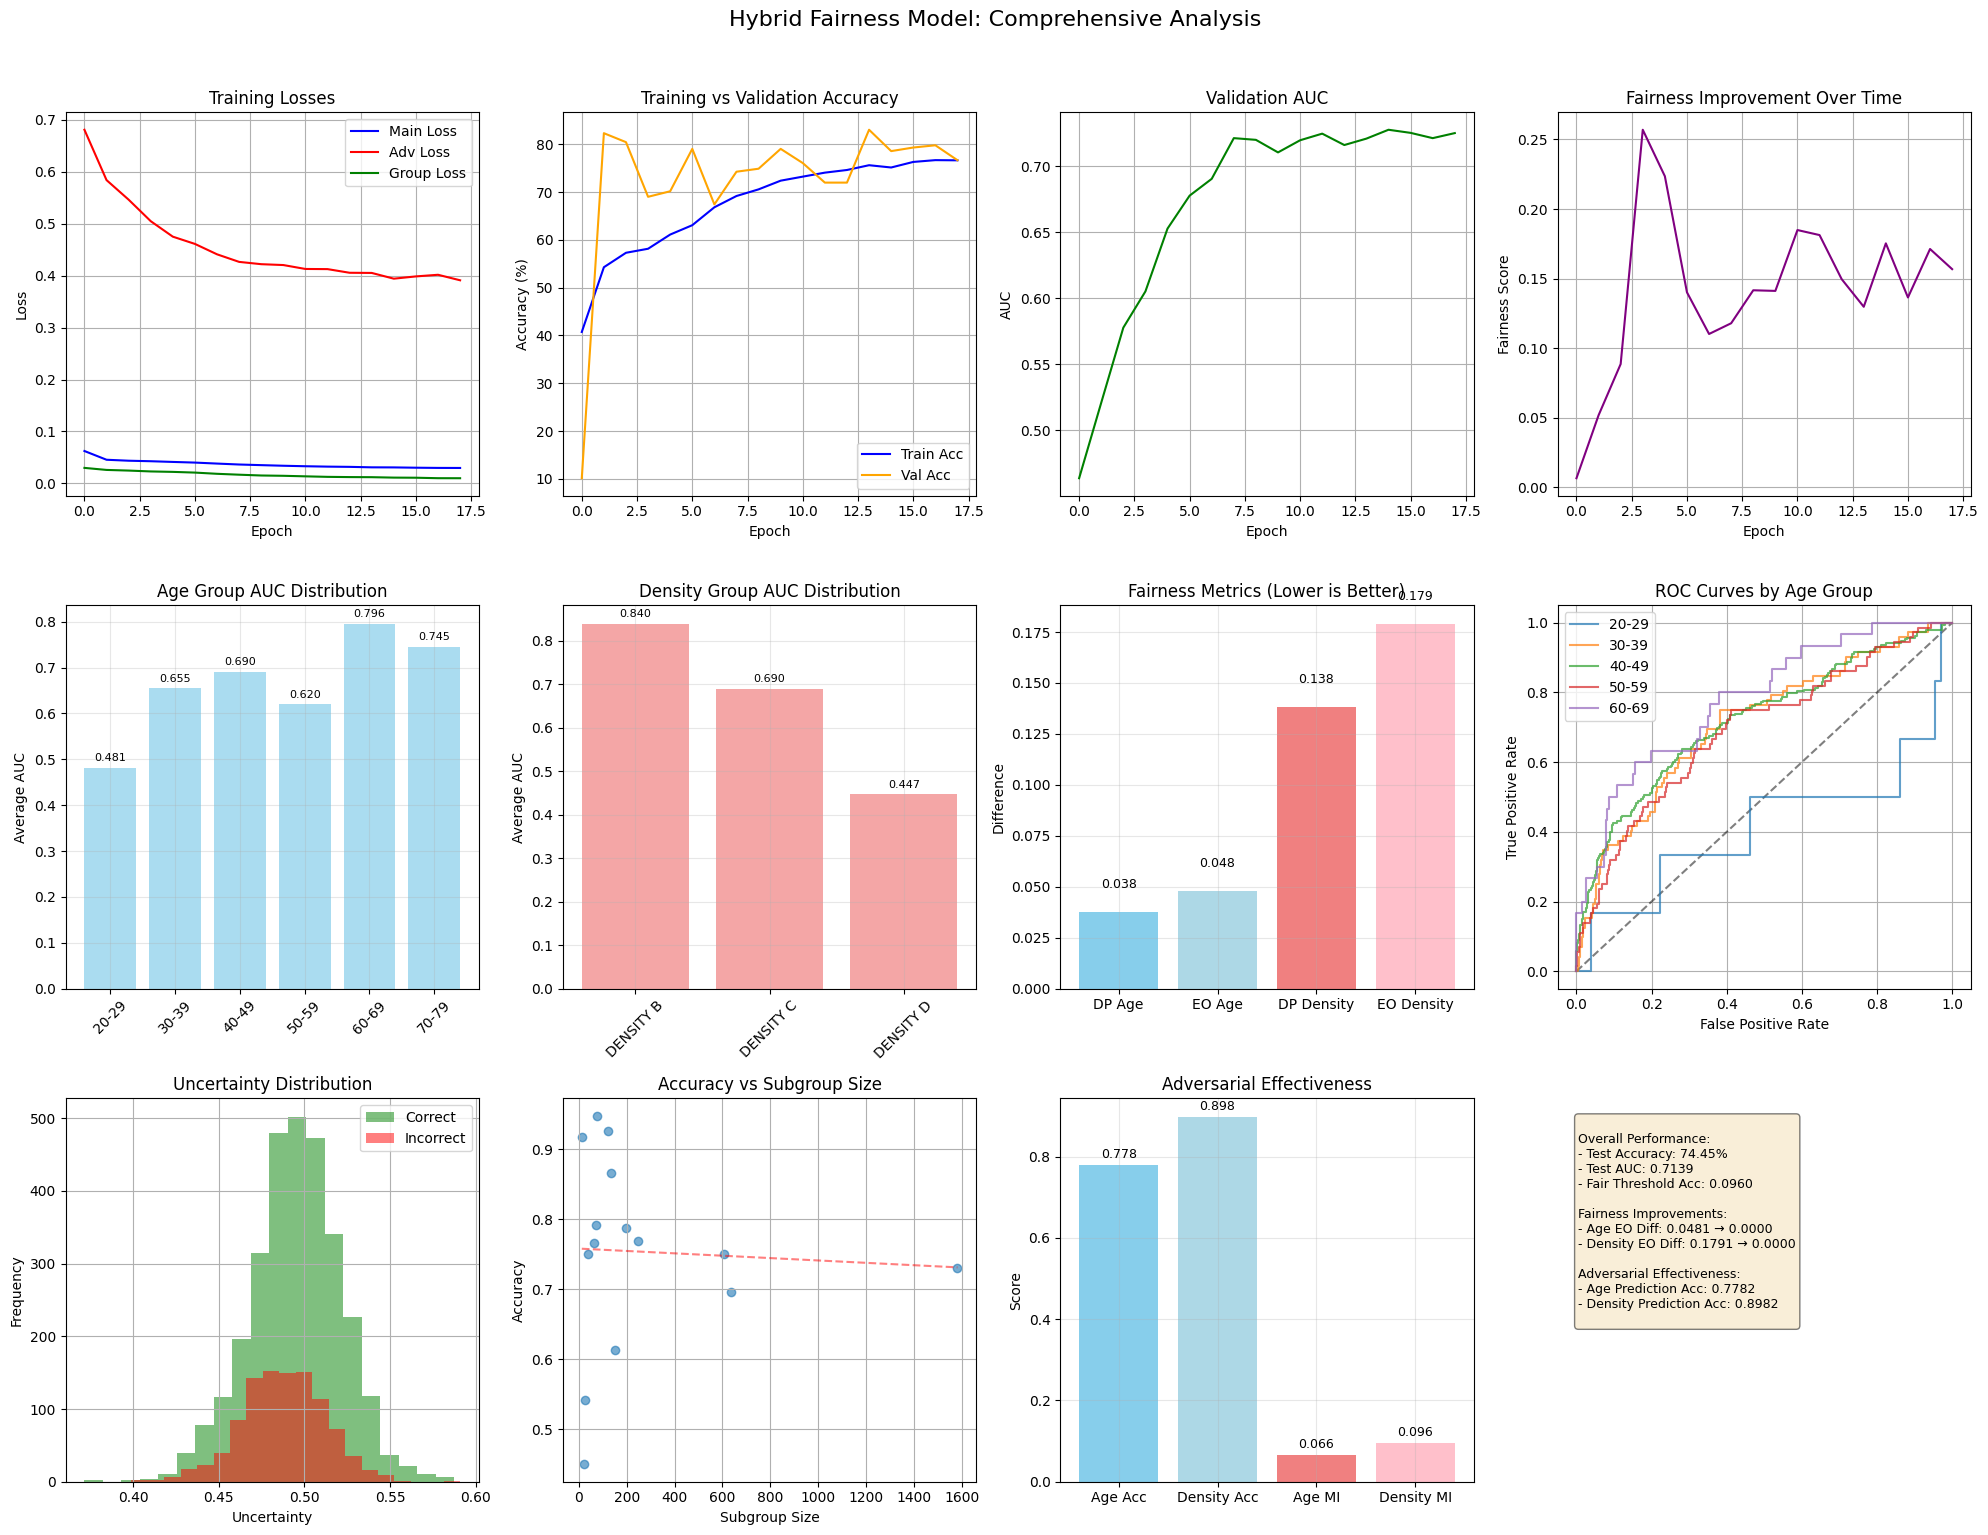

Visualizations saved to: /content/drive/MyDrive/IT_artefact/combinedfairnessintervention_checkpoints/


In [ ]:
#visualize the result

print(f"\n{'='*50}")
print("creating visual viwe")
print(f"{'='*50}")

fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# 1. Training losses
axes[0, 0].plot(train_history['main_loss'], label='Main Loss', color='blue')
axes[0, 0].plot(train_history['adv_loss'], label='Adv Loss', color='red')
axes[0, 0].plot(train_history['group_loss'], label='Group Loss', color='green')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Losses')
axes[0, 0].legend()
axes[0, 0].grid(True)

# 2. Training accuracy
axes[0, 1].plot(train_history['main_acc'], label='Train Acc', color='blue')
axes[0, 1].plot(train_history['val_acc'], label='Val Acc', color='orange')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training vs Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# 3. Validation AUC
axes[0, 2].plot(train_history['val_auc'], color='green')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('AUC')
axes[0, 2].set_title('Validation AUC')
axes[0, 2].grid(True)

# 4. Fairness metrics over time
axes[0, 3].plot(train_history['fairness_metrics'], color='purple')
axes[0, 3].set_xlabel('Epoch')
axes[0, 3].set_ylabel('Fairness Score')
axes[0, 3].set_title('Fairness Improvement Over Time')
axes[0, 3].grid(True)

# 5. Subgroup AUC distribution (Age)
age_aucs = []
age_names = []
for age in sorted(age_groups.keys()):
    group_metrics = age_groups[age]
    avg_auc = np.nanmean([m['auc'] for m in group_metrics if not np.isnan(m['auc'])])
    if not np.isnan(avg_auc):
        age_aucs.append(avg_auc)
        age_names.append(age)

bars = axes[1, 0].bar(range(len(age_aucs)), age_aucs, color='skyblue', alpha=0.7)
axes[1, 0].set_xticks(range(len(age_aucs)))
axes[1, 0].set_xticklabels(age_names, rotation=45)
axes[1, 0].set_ylabel('Average AUC')
axes[1, 0].set_title('Age Group AUC Distribution')
axes[1, 0].grid(True, alpha=0.3)

# Add values on bars
for bar, value in zip(bars, age_aucs):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=8)

# 6. Subgroup AUC distribution (Density)
density_aucs = []
density_names = []
for density in ['DENSITY A', 'DENSITY B', 'DENSITY C', 'DENSITY D']:
    if density in density_groups:
        group_metrics = density_groups[density]
        avg_auc = np.nanmean([m['auc'] for m in group_metrics if not np.isnan(m['auc'])])
        if not np.isnan(avg_auc):
            density_aucs.append(avg_auc)
            density_names.append(density)

bars = axes[1, 1].bar(range(len(density_aucs)), density_aucs, color='lightcoral', alpha=0.7)
axes[1, 1].set_xticks(range(len(density_aucs)))
axes[1, 1].set_xticklabels(density_names, rotation=45)
axes[1, 1].set_ylabel('Average AUC')
axes[1, 1].set_title('Density Group AUC Distribution')
axes[1, 1].grid(True, alpha=0.3)

# Add values on bars
for bar, value in zip(bars, density_aucs):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=8)

# 7. Fairness metrics comparison
fairness_comparison = ['DP Age', 'EO Age', 'DP Density', 'EO Density']
fairness_values = [
    fairness_metrics['dp_age_diff'],
    fairness_metrics['age_eo_diff'],
    fairness_metrics['dp_density_diff'],
    fairness_metrics['density_eo_diff']
]

bars = axes[1, 2].bar(fairness_comparison, fairness_values,
                      color=['skyblue', 'lightblue', 'lightcoral', 'pink'])
axes[1, 2].set_ylabel('Difference')
axes[1, 2].set_title('Fairness Metrics (Lower is Better)')
axes[1, 2].grid(True, alpha=0.3)

# Add values on bars
for bar, value in zip(bars, fairness_values):
    height = bar.get_height()
    axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=9)

# 8. ROC Curve by subgroup
from sklearn.metrics import roc_curve

# Plot ROC for each age group
axes[1, 3].plot([0, 1], [0, 1], 'k--', alpha=0.5)
for age in list(age_groups.keys())[:5]:  # Limit to 5 groups for clarity
    age_mask = test_df['Age Group'] == age
    if sum(age_mask) > 10:
        age_probs = test_probs[age_mask]
        age_labels = test_labels[age_mask]
        if len(np.unique(age_labels)) > 1:
            fpr, tpr, _ = roc_curve(age_labels, age_probs)
            axes[1, 3].plot(fpr, tpr, label=age, alpha=0.7)

axes[1, 3].set_xlabel('False Positive Rate')
axes[1, 3].set_ylabel('True Positive Rate')
axes[1, 3].set_title('ROC Curves by Age Group')
axes[1, 3].legend()
axes[1, 3].grid(True)

# 9. Uncertainty distribution
correct_uncertainty = test_uncertainties[test_correct]
incorrect_uncertainty = test_uncertainties[~test_correct]

axes[2, 0].hist(correct_uncertainty, bins=20, alpha=0.5, label='Correct', color='green')
axes[2, 0].hist(incorrect_uncertainty, bins=20, alpha=0.5, label='Incorrect', color='red')
axes[2, 0].set_xlabel('Uncertainty')
axes[2, 0].set_ylabel('Frequency')
axes[2, 0].set_title('Uncertainty Distribution')
axes[2, 0].legend()
axes[2, 0].grid(True)

# 10. Performance vs subgroup size
subgroup_sizes = []
subgroup_accuracies = []

for subgroup, metrics in subgroup_results.items():
    if metrics['n_samples'] > 10:
        subgroup_sizes.append(metrics['n_samples'])
        subgroup_accuracies.append(metrics['accuracy'])

axes[2, 1].scatter(subgroup_sizes, subgroup_accuracies, alpha=0.6)
axes[2, 1].set_xlabel('Subgroup Size')
axes[2, 1].set_ylabel('Accuracy')
axes[2, 1].set_title('Accuracy vs Subgroup Size')
axes[2, 1].grid(True)

# Add trend line
if len(subgroup_sizes) > 1:
    z = np.polyfit(subgroup_sizes, subgroup_accuracies, 1)
    p = np.poly1d(z)
    x_line = np.linspace(min(subgroup_sizes), max(subgroup_sizes), 100)
    axes[2, 1].plot(x_line, p(x_line), 'r--', alpha=0.5)

# 11. Adversarial effectiveness
adv_metrics = ['Age Acc', 'Density Acc', 'Age MI', 'Density MI']
adv_values = [adv_age_acc, adv_density_acc, adv_age_mi, adv_density_mi]

bars = axes[2, 2].bar(adv_metrics, adv_values, color=['skyblue', 'lightblue', 'lightcoral', 'pink'])
axes[2, 2].set_ylabel('Score')
axes[2, 2].set_title('Adversarial Effectiveness')
axes[2, 2].grid(True, alpha=0.3)

for bar, value in zip(bars, adv_values):
    height = bar.get_height()
    axes[2, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=9)

# 12. Summary statistics
summary_text = f"""
Overall Performance:
- Test Accuracy: {test_acc:.2f}%
- Test AUC: {test_auc:.4f}
- Fair Threshold Acc: {fair_acc:.4f}

Fairness Improvements:
- Age EO Diff: {fairness_metrics['age_eo_diff']:.4f} → {fair_metrics['age_eo_diff']:.4f}
- Density EO Diff: {fairness_metrics['density_eo_diff']:.4f} → {fair_metrics['density_eo_diff']:.4f}

Adversarial Effectiveness:
- Age Prediction Acc: {adv_age_acc:.4f}
- Density Prediction Acc: {adv_density_acc:.4f}
"""

axes[2, 3].text(0.05, 0.95, summary_text, transform=axes[2, 3].transAxes,
                fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[2, 3].axis('off')

plt.suptitle('Hybrid Fairness Model: Comprehensive Analysis', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(CHECKPOINT_path, 'hybrid_fairness_comprehensive_analysis.png'),
            dpi=300, bbox_inches='tight')
plt.show()

print(f"Visualizations saved to: {CHECKPOINT_path}")



# **Clinical guidance from fairness analysis**

In [ ]:
#recommendation

"""
This code help togenerates practical recommendations based on the model's
performance, subgroup evaluation, and fairness analysis.
first : regarding the Model selection:give the optimal decision threshold that balances fairness and overall performance.
and gives alternative thresholds for clinical and screening use cases.
second :subgroup analysis:Identifies the worstand the bestperforming subgroups based on AUC and accuracy.
in addition to , fairness Assessment:calculate  (DIR) against the four-fifths rule.
   show if age or density groups fail fairness criteria.
  then suggest  actionable insights for potential mitigation or auditing.

so my aim to give actionable summary for the clinicians or who will use this faireness aware interfention in transparent way
"""

print(f"\n{'='*50}")
print("Recommendation ")
print(f"{'='*50}")

print(f"\n1. Model Selection:")
print(f"   - Use threshold {fair_threshold:.3f} for optimal fairness-performance trade-off")
print(f"   - For clinical use: {fair_threshold:.3f}")
print(f"   - For screening: 0.5 (higher sensitivity)")

print(f"\n2. Subgroups requiring attention:")
# Identify worst-performing subgroups
worst_subgroups = sorted(subgroup_results.items(),
                         key=lambda x: x[1]['auc'] if not np.isnan(x[1]['auc']) else 0)[:3]

print(f"   Top 3 worst-performing subgroups:")
for subgroup, metrics in worst_subgroups:
    print(f"     - {subgroup}: AUC={metrics['auc']:.3f}, Acc={metrics['accuracy']:.3f}")

print(f"\n3. Fairness assessment:")
if age_dir >= 0.8 and density_dir >= 0.8:
    print(f"    PASSES four-fifths rule for both age and density")
else:
    print(f"   ✗ FAILS four-fifths rule:")
    if age_dir < 0.8:
        print(f"     - Age groups (DIR: {age_dir:.3f})")
    if density_dir < 0.8:
        print(f"     - Density groups (DIR: {density_dir:.3f})")




Recommendation 

1. Model Selection:
   - Use threshold 0.100 for optimal fairness-performance trade-off
   - For clinical use: 0.100
   - For screening: 0.5 (higher sensitivity)

2. Subgroups requiring attention:
   Top 3 worst-performing subgroups:
     - 30-39_DENSITY B: AUC=nan, Acc=0.917
     - 40-49_DENSITY A: AUC=nan, Acc=1.000
     - 60-69_DENSITY A: AUC=nan, Acc=1.000

3. Fairness assessment:
   ✗ FAILS four-fifths rule:
     - Density groups (DIR: 0.507)


## Explainability tools

visual and numerical analysis


GRAD-CAM Visualization for combined model

Generating Grad-CAM visualizations for selected samples...

Selecting samples with emphasis on minority class (BI-RADS 3-4-5)...


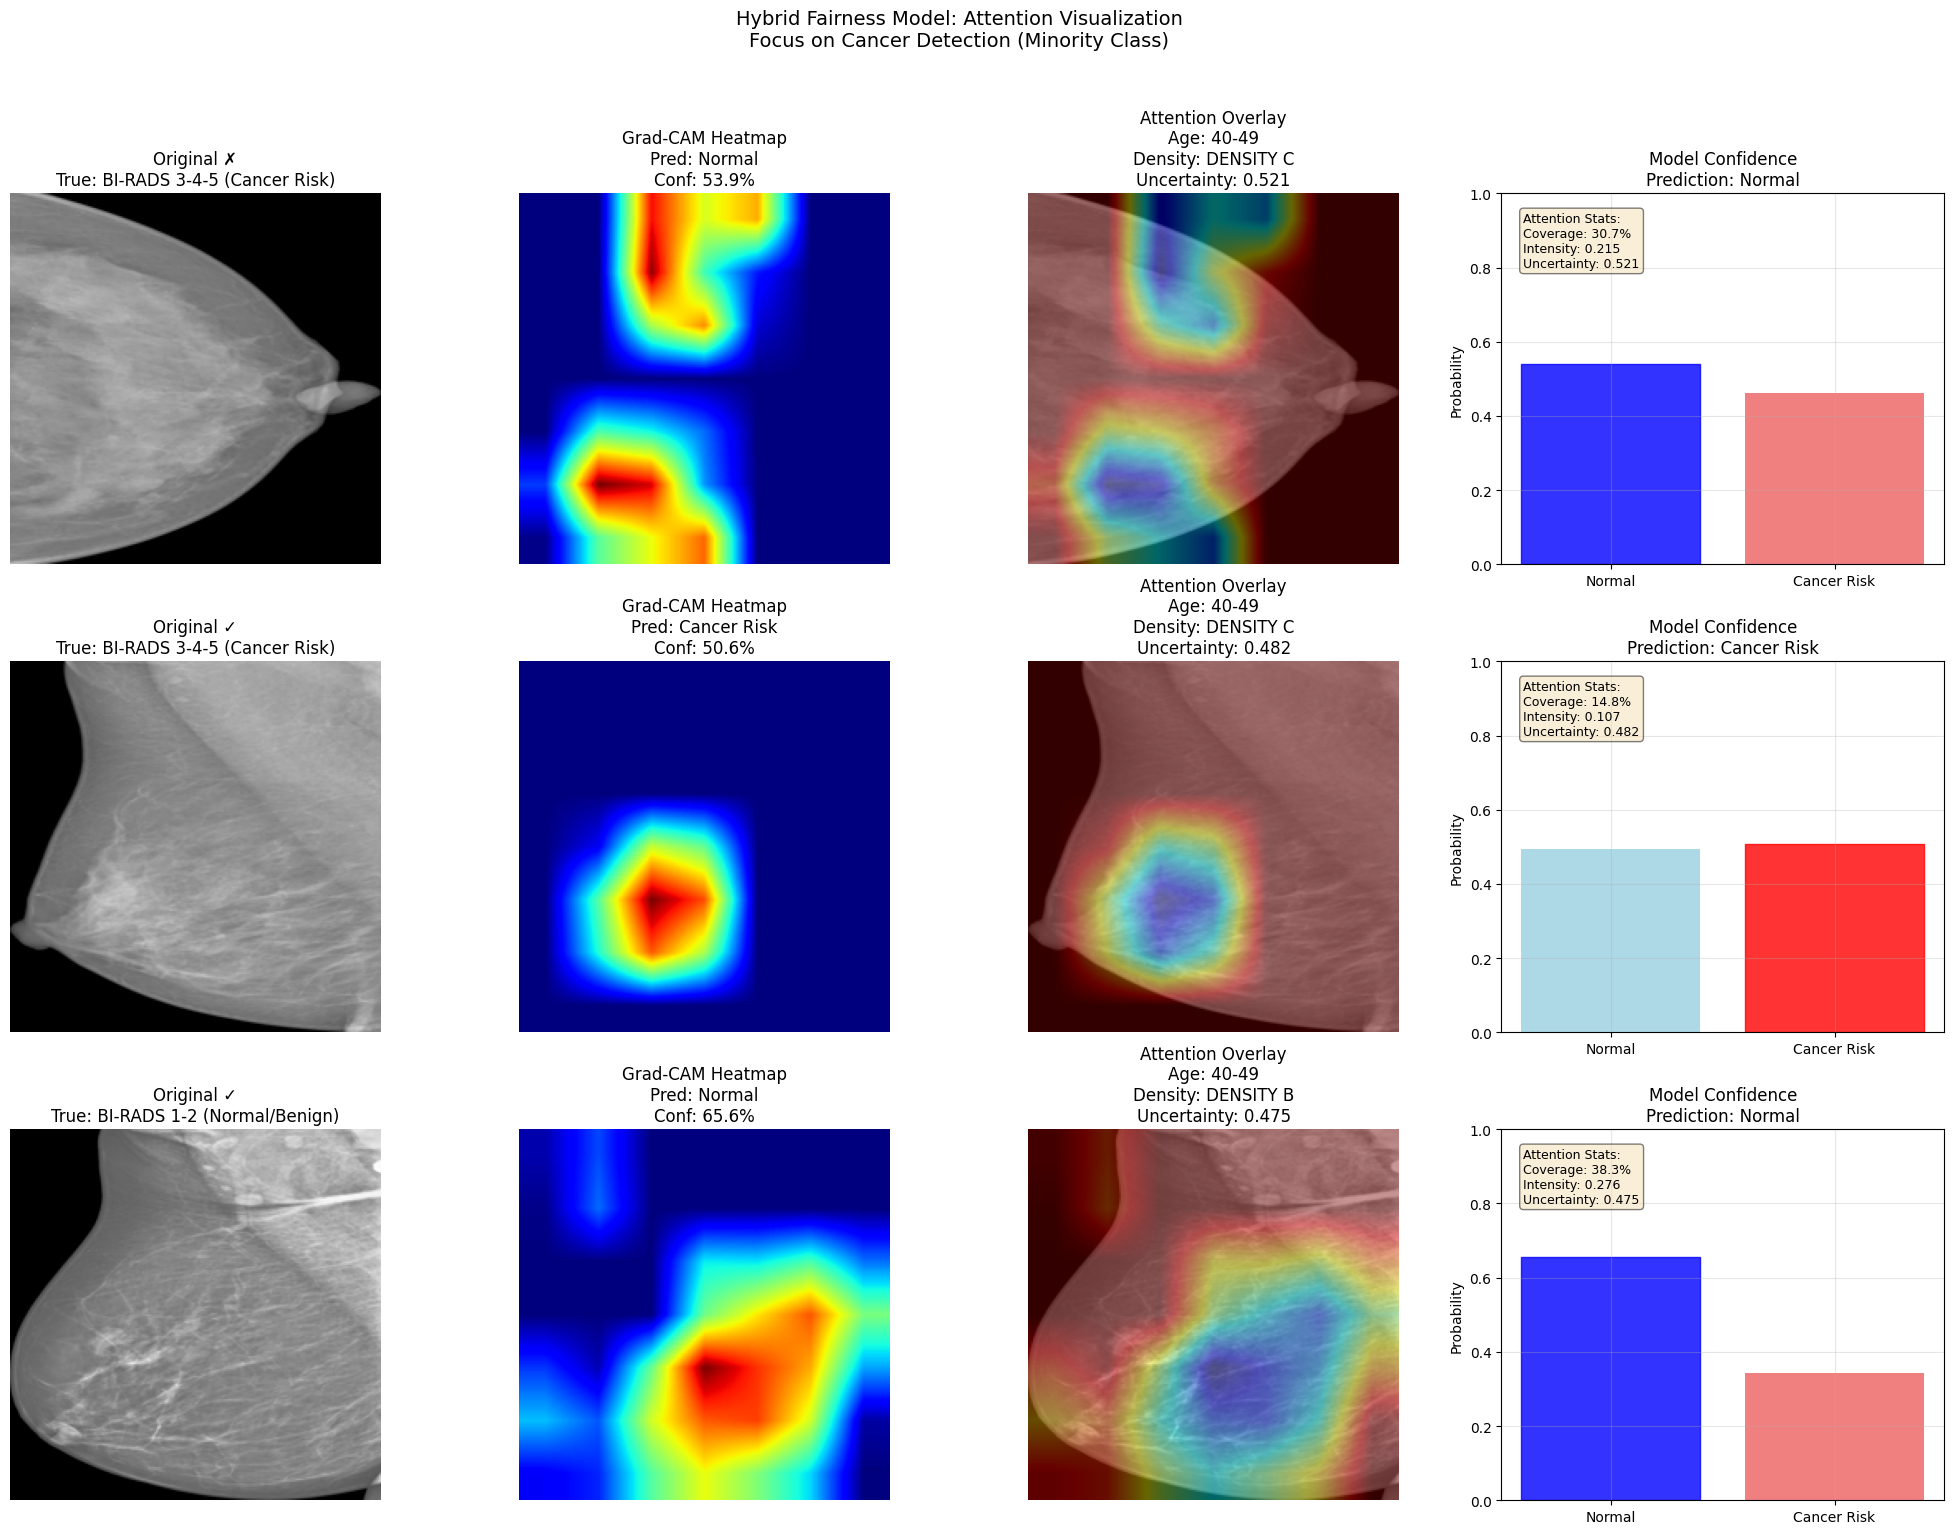

Grad-CAM visualizations saved to: /content/drive/MyDrive/IT_artefact/combinedfairnessintervention_checkpoints/hybrid_fairness_gradcam.png


In [ ]:

# GRAD-CAM visualization and numerical analysis


print("\n" + "="*50)
print("GRAD-CAM Visualization for combined model")
print("="*50)

class HybridGradCAMWrapper:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output.detach()

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()

        # Forward pass to get main outputs only
        outputs = self.model(input_tensor, return_uncertainty=False)
        main_output = outputs['main']

        # I use predicted class
        if class_idx is None:
            class_idx = main_output.argmax(dim=1).item()

        # Backward pass for specified class
        one_hot = torch.zeros_like(main_output)
        one_hot[0, class_idx] = 1
        main_output.backward(gradient=one_hot)

        # Calculate weights
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)

        # Generate CAM
        cam = torch.sum(weights * self.activations, dim=1)
        cam = torch.relu(cam)
        cam = cam.squeeze().cpu().numpy()

        # Resize to input size
        cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam, class_idx, main_output

# samples visualization
print("\nGenerating Grad-CAM visualizations for selected samples...")

# Get last convolutional layer in DenseNet
target_layer = model.backbone.features[-1]

# Create Grad-CAM wrapper
gradcam = HybridGradCAMWrapper(model, target_layer)

# visualization mainly minority class (BI-RADS 3-4-5)
print("\nSelecting samples with emphasis on minority class (BI-RADS 3-4-5)...")

# Get minority class samples
minority_samples = test_df[test_df['binary_label'] == 1].index.tolist()
majority_samples = test_df[test_df['binary_label'] == 0].index.tolist()

# Select samples (2 minority, 1 majority for comparison)
selected_indices = []
if len(minority_samples) >= 2:
    selected_indices.extend(np.random.choice(minority_samples, 2, replace=False))
if len(majority_samples) >= 1:
    selected_indices.extend(np.random.choice(majority_samples, 1, replace=False))

# If no minority samples, use random samples
if not selected_indices:
    selected_indices = np.random.choice(len(test_df), min(3, len(test_df)), replace=False)

fig, axes = plt.subplots(len(selected_indices), 4, figsize=(20, 5*len(selected_indices)))

if len(selected_indices) == 1:
    axes = axes.reshape(1, -1)

for idx, (ax_row, sample_idx) in enumerate(zip(axes, selected_indices)):
    sample = test_df.iloc[sample_idx]

    # Load and prepare image
    img_path = sample['preprocessed_path']
    try:
        original_img = Image.open(img_path).convert('RGB')
    except:
        # If image can't be loaded, create a black image
        original_img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')

    input_tensor = val_transform(original_img).unsqueeze(0).to(DEVICE)

    # Get prediction and uncertainty
    with torch.no_grad():
        outputs = model(input_tensor, return_uncertainty=True)
        main_output = outputs['main']
        probs = torch.softmax(main_output, dim=1)[0]
        pred_class = main_output.argmax(dim=1).item()
        pred_prob = probs[pred_class].item()
        true_label = sample['binary_label']
        uncertainty = outputs['uncertainty'].item() if outputs['uncertainty'] is not None else 0.5

    # Generate Grad-CAM
    cam, _, _ = gradcam.generate(input_tensor, pred_class)

    # Prepare images to show them
    display_img = np.array(original_img.resize((IMG_SIZE, IMG_SIZE)))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(display_img, 0.6, heatmap, 0.4, 0)

    # Original image
    ax_row[0].imshow(display_img)
    correct_icon = "✓" if pred_class == true_label else "✗"
    class_description = "BI-RADS 3-4-5 (Cancer Risk)" if true_label == 1 else "BI-RADS 1-2 (Normal/Benign)"
    ax_row[0].set_title(f"Original {correct_icon}\nTrue: {class_description}")
    ax_row[0].axis('off')

    # Heatmap
    ax_row[1].imshow(cam, cmap='jet')
    ax_row[1].set_title(f"Grad-CAM Heatmap\nPred: {'Cancer Risk' if pred_class == 1 else 'Normal'}\nConf: {pred_prob:.1%}")
    ax_row[1].axis('off')

    # Overlay
    ax_row[2].imshow(overlay)
    demographic_info = f"Age: {sample['Age Group']}\nDensity: {sample['breast_density']}"
    ax_row[2].set_title(f"Attention Overlay\n{demographic_info}\nUncertainty: {uncertainty:.3f}")
    ax_row[2].axis('off')

    # Probability distribution
    bars = ax_row[3].bar(['Normal', 'Cancer Risk'], probs.cpu().numpy(),
                        color=['lightblue', 'lightcoral'])
    ax_row[3].set_ylim([0, 1])
    ax_row[3].set_title(f"Model Confidence\nPrediction: {'Cancer Risk' if pred_class == 1 else 'Normal'}")
    ax_row[3].set_ylabel("Probability")
    ax_row[3].grid(True, alpha=0.3)

    # Highlight predicted class
    bars[pred_class].set_color('red' if pred_class == 1 else 'blue')
    bars[pred_class].set_alpha(0.8)

    # Add attention analysis text
    coverage = np.mean(cam > 0.3) * 100
    intensity = np.mean(cam)
    text_str = f"Attention Stats:\nCoverage: {coverage:.1f}%\nIntensity: {intensity:.3f}\nUncertainty: {uncertainty:.3f}"
    ax_row[3].text(0.05, 0.95, text_str, transform=ax_row[3].transAxes,
                  fontsize=9, verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Hybrid Fairness Model: Attention Visualization\nFocus on Cancer Detection (Minority Class)',
             fontsize=14, y=1.02)
plt.tight_layout()
gradcam_path = os.path.join(CHECKPOINT_path, 'hybrid_fairness_gradcam.png')
plt.savefig(gradcam_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Grad-CAM visualizations saved to: {gradcam_path}")


complementary numerical analysis

In [ ]:
# GRAD-CAM statistical analysis

print("\n" + "="*50)
print("GRAD-CAM FAIRNESS ANALYSIS ACROSS SUBGROUPS")
print("="*50)

def analyze_heatmap_with_fairness(cam, threshold=0.3):
    # Enhanced analysis of heatmap with fairness metrics
    # Basic statistics
    coverage = np.mean(cam > threshold) * 100
    avg_intensity = np.mean(cam)
    max_intensity = np.max(cam)

    # Find connected regions for analysis
    binary_mask = (cam > threshold).astype(np.uint8)
    num_labels = cv2.connectedComponents(binary_mask, connectivity=8)[0] - 1

    # Spatial analysis
    y_indices, x_indices = np.where(cam > threshold)
    if len(y_indices) > 0 and len(x_indices) > 0:
        center_of_mass_y = np.mean(y_indices) / IMG_SIZE
        center_of_mass_x = np.mean(x_indices) / IMG_SIZE
        spatial_spread = np.std(y_indices) * np.std(x_indices) / (IMG_SIZE * IMG_SIZE)
    else:
        center_of_mass_y = center_of_mass_x = spatial_spread = 0

    return {
        'coverage': coverage,
        'avg_intensity': avg_intensity,
        'max_intensity': max_intensity,
        'num_regions': num_labels,
        'center_of_mass': (center_of_mass_x, center_of_mass_y),
        'spatial_spread': spatial_spread
    }

# Analyze multiple samples across demographic groups
print("\nAnalyzing attention patterns across demographic groups...")

num_samples = min(100, len(test_df))
sample_indices = np.random.choice(len(test_df), num_samples, replace=False)

# Group analyses by demographic
age_group_analyses = {}
density_group_analyses = {}

for i, sample_idx in enumerate(sample_indices):
    if i % 20 == 0:
        print(f"  Processing sample {i+1}/{num_samples}...")

    sample = test_df.iloc[sample_idx]

    try:
        # Load and prepare image and predict
        img_path = sample['preprocessed_path']
        original_img = Image.open(img_path).convert('RGB')
        input_tensor = val_transform(original_img).unsqueeze(0).to(DEVICE)


        with torch.no_grad():
            outputs = model(input_tensor, return_uncertainty=True)
            main_output = outputs['main']
            pred_class = main_output.argmax(dim=1).item()

        # analyse
        cam, _, _ = gradcam.generate(input_tensor, pred_class)
        analysis = analyze_heatmap_with_fairness(cam)

        # Add metadata
        analysis['is_correct'] = (pred_class == sample['binary_label'])
        analysis['age_group'] = sample['Age Group']
        analysis['density'] = sample['breast_density']
        analysis['pred_class'] = pred_class
        analysis['true_class'] = sample['binary_label']

        # Get uncertainty
        with torch.no_grad():
            outputs = model(input_tensor, return_uncertainty=True)
            analysis['uncertainty'] = outputs['uncertainty'].item() if outputs['uncertainty'] is not None else 0.5

        # Group by demographics
        age_group = sample['Age Group']
        density = sample['breast_density']

        if age_group not in age_group_analyses:
            age_group_analyses[age_group] = []
        age_group_analyses[age_group].append(analysis)

        if density not in density_group_analyses:
            density_group_analyses[density] = []
        density_group_analyses[density].append(analysis)

    except Exception as e:
        continue

# Print fairness analysis
print(f"\nFAIRNESS ANALYSIS BY AGE GROUP")
print("-" * 60)
print(f"{'Age Group':<10} {'Samples':<8} {'Accuracy':<10} {'Coverage%':<12} {'Intensity':<12} {'Uncertainty':<12}")
print("-" * 60)

age_groups_sorted = sorted([ag for ag in age_group_analyses.keys() if age_group_analyses[ag]],
                          key=lambda x: int(x.split('-')[0]) if '-' in x else 0)

for age_group in age_groups_sorted:
    analyses = age_group_analyses[age_group]
    n_samples = len(analyses)
    accuracy = np.mean([a['is_correct'] for a in analyses])
    avg_coverage = np.mean([a['coverage'] for a in analyses])
    avg_intensity = np.mean([a['avg_intensity'] for a in analyses])
    avg_uncertainty = np.mean([a['uncertainty'] for a in analyses])

    print(f"{age_group:<10} {n_samples:<8} {accuracy:.3f}     {avg_coverage:<10.1f}   {avg_intensity:<10.3f}  {avg_uncertainty:<10.3f}")

print(f"\nFAIRNESS ANALYSIS BY BREAST DENSITY")
print("-" * 60)
print(f"{'Density':<12} {'Samples':<8} {'Accuracy':<10} {'Coverage%':<12} {'Intensity':<12} {'Uncertainty':<12}")
print("-" * 60)

density_order = ['DENSITY A', 'DENSITY B', 'DENSITY C', 'DENSITY D']
for density in density_order:
    if density in density_group_analyses and density_group_analyses[density]:
        analyses = density_group_analyses[density]
        n_samples = len(analyses)
        accuracy = np.mean([a['is_correct'] for a in analyses])
        avg_coverage = np.mean([a['coverage'] for a in analyses])
        avg_intensity = np.mean([a['avg_intensity'] for a in analyses])
        avg_uncertainty = np.mean([a['uncertainty'] for a in analyses])

        print(f"{density:<12} {n_samples:<8} {accuracy:.3f}     {avg_coverage:<10.1f}   {avg_intensity:<10.3f}  {avg_uncertainty:<10.3f}")

# Calculate fairness disparities
print(f"\nATTENTION PATTERN DISPARITIES")
print("-" * 60)

def calculate_disparities(group_stats, metric_key):
    values = [group_stats[g][metric_key] for g in group_stats if g in group_stats]
    if len(values) < 2:
        return 0, 0
    return max(values) - min(values), np.std(values)

# Age group disparities
age_coverage_range, age_coverage_std = calculate_disparities(
    {g: {'coverage': np.mean([a['coverage'] for a in age_group_analyses[g]])}
     for g in age_groups_sorted if g in age_group_analyses}, 'coverage')

age_intensity_range, age_intensity_std = calculate_disparities(
    {g: {'intensity': np.mean([a['avg_intensity'] for a in age_group_analyses[g]])}
     for g in age_groups_sorted if g in age_group_analyses}, 'intensity')

age_accuracy_range, age_accuracy_std = calculate_disparities(
    {g: {'accuracy': np.mean([a['is_correct'] for a in age_group_analyses[g]])}
     for g in age_groups_sorted if g in age_group_analyses}, 'accuracy')

print(f"Age Group Disparities:")
print(f"  Coverage: Range = {age_coverage_range:.1f}%, Std = {age_coverage_std:.1f}")
print(f"  Intensity: Range = {age_intensity_range:.3f}, Std = {age_intensity_std:.3f}")
print(f"  Accuracy: Range = {age_accuracy_range:.3f}, Std = {age_accuracy_std:.3f}")

# Density group disparities
density_coverage_range, density_coverage_std = calculate_disparities(
    {d: {'coverage': np.mean([a['coverage'] for a in density_group_analyses[d]])}
     for d in density_order if d in density_group_analyses}, 'coverage')

density_intensity_range, density_intensity_std = calculate_disparities(
    {d: {'intensity': np.mean([a['avg_intensity'] for a in density_group_analyses[d]])}
     for d in density_order if d in density_group_analyses}, 'intensity')

density_accuracy_range, density_accuracy_std = calculate_disparities(
    {d: {'accuracy': np.mean([a['is_correct'] for a in density_group_analyses[d]])}
     for d in density_order if d in density_group_analyses}, 'accuracy')

print(f"\nDensity Group Disparities:")
print(f"  Coverage: Range = {density_coverage_range:.1f}%, Std = {density_coverage_std:.1f}")
print(f"  Intensity: Range = {density_intensity_range:.3f}, Std = {density_intensity_std:.3f}")
print(f"  Accuracy: Range = {density_accuracy_range:.3f}, Std = {density_accuracy_std:.3f}")

# Key insights
print(f"\nKEY INSIGHTS:")
if age_coverage_range > 15:
    print(f"  • Significant attention coverage disparity across age groups ({age_coverage_range:.1f}% range)")
if density_intensity_range > 0.2:
    print(f"  • Large attention intensity differences across density groups ({density_intensity_range:.3f} range)")
if age_accuracy_range > 0.1:
    print(f"  • Accuracy varies meaningfully by age ({age_accuracy_range:.3f} range)")
if density_accuracy_range > 0.1:
    print(f"  • Accuracy varies meaningfully by density ({density_accuracy_range:.3f} range)")

print("\n" + "="*50)
print("HYBRID MODEL GRAD-CAM ANALYSIS COMPLETE")
print("="*50)


GRAD-CAM FAIRNESS ANALYSIS ACROSS SUBGROUPS

Analyzing attention patterns across demographic groups...
  Processing sample 1/100...
  Processing sample 21/100...
  Processing sample 41/100...
  Processing sample 61/100...
  Processing sample 81/100...

FAIRNESS ANALYSIS BY AGE GROUP
------------------------------------------------------------
Age Group  Samples  Accuracy   Coverage%    Intensity    Uncertainty 
------------------------------------------------------------
20-29      5        0.800     35.8         0.251       0.489     
30-39      17       0.647     27.5         0.194       0.490     
40-49      52       0.731     31.4         0.221       0.491     
50-59      18       0.722     27.8         0.205       0.493     
60-69      7        0.714     31.4         0.234       0.481     
70-79      1        1.000     59.9         0.395       0.454     

FAIRNESS ANALYSIS BY BREAST DENSITY
------------------------------------------------------------
Density      Samples  Accurac

# **fixed attention fairness fine-tuning**

In [ ]:
#simple attention fairness

def calculate_simple_attention_fairness(model, images, age_attrs, density_attrs):
    """
    Feature-variance-based fairness loss
    """
    # Extract features from backbone
    with torch.no_grad():
        if hasattr(model, 'get_shared_features'):
            features = model.get_shared_features(images)
        else:
            features = model.backbone(images)

    # Age
    age_var_loss = torch.tensor(0.0, device=images.device, requires_grad=True)
    unique_ages = torch.unique(age_attrs)
    for age in unique_ages:
        age_mask = (age_attrs == age)
        if torch.sum(age_mask) > 1:
            age_features = features[age_mask]
            age_var_loss = age_var_loss + torch.var(age_features, dim=0).mean()

    # Density
    density_var_loss = torch.tensor(0.0, device=images.device, requires_grad=True)
    unique_densities = torch.unique(density_attrs)
    for density in unique_densities:
        density_mask = (density_attrs == density)
        if torch.sum(density_mask) > 1:
            density_features = features[density_mask]
            density_var_loss = density_var_loss + torch.var(density_features, dim=0).mean()

    # Normalize
    n_age = max(1, len(unique_ages))
    n_density = max(1, len(unique_densities))
    return (age_var_loss / n_age + density_var_loss / n_density) / 10  # scaled down

#fine tone epoch function

def fine_tune_epoch(model, loader, main_optimizer, adversary_optimizer,
                    focal_loss, adversary_criterion, device,
                    epoch, total_epochs):
    #One epoch of gradient-tracked fine-tuning
    model.train()
    total_main_loss, total_fairness_loss = 0.0, 0.0
    correct_main, total_samples = 0, 0

    pbar = tqdm(loader, desc=f"Fine-tuning Epoch {epoch+1}/{total_epochs}")

    for images, main_labels, age_attrs, density_attrs, _ in pbar:
        images, main_labels = images.to(device), main_labels.to(device)
        age_attrs, density_attrs = age_attrs.to(device), density_attrs.to(device)

        main_optimizer.zero_grad()
        if adversary_optimizer: adversary_optimizer.zero_grad()

        outputs = model(images, return_uncertainty=False)
        main_output = outputs['main']

        # Main loss
        main_loss = focal_loss(main_output, main_labels)

        # Fairness loss
        fairness_loss = calculate_simple_attention_fairness(model, images, age_attrs, density_attrs)

        # Combined loss
        total_loss = main_loss + 0.01 * fairness_loss
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        main_optimizer.step()
        if adversary_optimizer: adversary_optimizer.step()

        total_main_loss += main_loss.item()
        total_fairness_loss += fairness_loss.item()
        _, main_preds = main_output.max(1)
        correct_main += main_preds.eq(main_labels).sum().item()
        total_samples += main_labels.size(0)

        pbar.set_postfix({
            'Main Loss': f'{main_loss.item():.4f}',
            'Fair Loss': f'{fairness_loss.item():.4f}',
            'Acc': f'{100.*correct_main/total_samples:.1f}%'
        })

    return total_main_loss / len(loader), total_fairness_loss / len(loader), 100. * correct_main / total_samples

# initial validation

initial_val_loss, initial_val_acc, initial_val_auc, val_details = hybrid_validate(
    model, val_loader, focal_loss, DEVICE, return_detailed=True
)
print(f"\nInitial Validation -> Loss: {initial_val_loss:.4f}, Acc: {initial_val_acc:.2f}%, AUC: {initial_val_auc:.4f}")

#fine tuning loop

FINE_TUNE_EPOCHS = 3
best_val_auc = initial_val_auc

for epoch in range(FINE_TUNE_EPOCHS):
    print(f"\n{'='*50}")
    print(f"Fine-tuning Epoch {epoch+1}/{FINE_TUNE_EPOCHS}")
    print(f"{'='*50}")

    avg_main_loss, avg_fairness_loss, main_acc = fine_tune_epoch(
        model, train_loader, main_optimizer, adversary_optimizer,
        focal_loss, adversary_criterion, DEVICE,
        epoch, FINE_TUNE_EPOCHS
    )

    print(f"\nEpoch results:")
    print(f"  Training loss: {avg_main_loss:.4f}, Acc: {main_acc:.2f}%")
    print(f"  Fairness loss: {avg_fairness_loss:.4f}")

    # Validation
    val_loss, val_acc, val_auc, val_details = hybrid_validate(model, val_loader, focal_loss, DEVICE, return_detailed=True)
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val AUC: {val_auc:.4f}")

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        print(f"  ✅ New best validation AUC!")

#final evaluation

print("\nRunning final comprehensive validation...")
val_loss, val_acc, val_auc, val_details = hybrid_validate(model, val_loader, focal_loss, DEVICE, return_detailed=True)
fairness_metrics = calculate_fairness_metrics_from_results(val_details)
fairness_score = max(fairness_metrics['age_eo_diff'], fairness_metrics['density_eo_diff'])

print(f"\nFinal model performance:")
print(f"  Validation AUC: {val_auc:.4f} (Initial: {initial_val_auc:.4f})")
print(f"  Validation accuracy: {val_acc:.2f}% (Initial: {initial_val_acc:.2f}%)")
print(f"  Fairness score: {fairness_score:.4f}")
print(f"  Age EO difference: {fairness_metrics['age_eo_diff']:.4f}")
print(f"  Density EO difference: {fairness_metrics['density_eo_diff']:.4f}")


Validation: 100%|██████████| 100/100 [00:06<00:00, 15.65it/s]



Initial Validation -> Loss: 0.0338, Acc: 76.66%, AUC: 0.7187

Fine-tuning Epoch 1/3


Fine-tuning Epoch 1/3: 100%|██████████| 400/400 [00:48<00:00,  8.31it/s, Main Loss=0.0432, Fair Loss=0.1687, Acc=70.5%]



Epoch results:
  Training loss: 0.0353, Acc: 70.47%
  Fairness loss: 0.1767


Validation: 100%|██████████| 100/100 [00:06<00:00, 15.74it/s]


  Val Loss: 0.0336, Val Acc: 76.53%, Val AUC: 0.7134

Fine-tuning Epoch 2/3


Fine-tuning Epoch 2/3: 100%|██████████| 400/400 [00:47<00:00,  8.42it/s, Main Loss=0.0353, Fair Loss=0.1842, Acc=71.1%]



Epoch results:
  Training loss: 0.0354, Acc: 71.08%
  Fairness loss: 0.1764


Validation: 100%|██████████| 100/100 [00:06<00:00, 16.17it/s]


  Val Loss: 0.0348, Val Acc: 75.59%, Val AUC: 0.7154

Fine-tuning Epoch 3/3


Fine-tuning Epoch 3/3: 100%|██████████| 400/400 [00:46<00:00,  8.51it/s, Main Loss=0.0398, Fair Loss=0.1730, Acc=70.9%]



Epoch results:
  Training loss: 0.0349, Acc: 70.88%
  Fairness loss: 0.1767


Validation: 100%|██████████| 100/100 [00:06<00:00, 16.00it/s]


  Val Loss: 0.0327, Val Acc: 77.94%, Val AUC: 0.7162

Running final comprehensive validation...


Validation: 100%|██████████| 100/100 [00:06<00:00, 15.81it/s]


Final model performance:
  Validation AUC: 0.7162 (Initial: 0.7187)
  Validation accuracy: 77.94% (Initial: 76.66%)
  Fairness score: 0.0586
  Age EO difference: 0.0504
  Density EO difference: 0.0586
